In [1]:
import struct
import pandas as pd
import numpy as np
import os
from image_header import ImageHeader
import matplotlib.pyplot as plt

# Transform binary data to pd.DataFrame

In [2]:
struct_fmt = '=lldddddddddd' # int[5], float, byte[255]
struct_len = struct.calcsize(struct_fmt)
struct_unpack = struct.Struct(struct_fmt).unpack_from

struct_fmt2 = '=hhddddddddccccfhhhhh' # int[5], float, byte[255]
struct_len2 = struct.calcsize(struct_fmt2)
struct_unpack2 = struct.Struct(struct_fmt2).unpack_from

results = []
filename = 'outputIM.bin'
with open(filename, "rb") as f:
    while True:
        data1 = f.read(struct_len)
        if not data1:
            break
        s1 = struct_unpack(data1)
        # print(s1)
        for i in range(0, 97):
            data2 = f.read(struct_len2)
            if not data2:
                break
            s2 = struct_unpack2(data2) + s1
            results.append(s2)
f.close()
            

pnts = pd.DataFrame(results, columns=['row', 'col', 'x', 'y', 'z', 'norm_x', 'norm_y', 'norm_z',
                                      'alpha', 'radius', 'vis1', 'vis2', 'vis3', 'vis4', 'hrel',
                                      'R', 'G', 'B', 'N', 'P',
                                     'Serial', 'ImageCode', 'ViewZenith', 'SunAzimuth', 'SunElevation', 'AzimDiff',
                                     'SunVecX', 'SunVecY', 'SunVecZ', 'CamVecX', 'CamVecY', 'CamVecZ'])

# Transform visibilities to integers
pnts[['vis1', 'vis2', 'vis3', 'vis4']] = pnts[['vis1', 'vis2', 'vis3', 'vis4']].astype(int)
print(pnts.shape)

# Assign class to visibility
pnts['visibility'] = 'sunlit'
pnts.loc[(pnts['vis1'] == 1), 'visibility'] = 'self_shadowed'
pnts.loc[(pnts['vis2'] == 1), 'visibility'] = 'self_occluded'
pnts.loc[(pnts['vis3'] == 1), 'visibility'] = 'shadowed'
pnts.loc[(pnts['vis4'] == 1), 'visibility'] = 'occluded'


# Transform data
pnts['SunElevation'] = 90 - np.degrees(pnts['SunElevation'])
pnts['SunAzimuth'] = np.degrees(pnts['SunAzimuth'])

# Read tree-data and merge with point-data
young = pd.read_csv('/home/markus/Documents/Gradu2021/nuori_metsa_puut.csv')
pnts = pd.merge(pnts, young, left_on='Serial', right_on='Serial')
print(pnts.shape)

# Calculate additional angles to restrict used pixel values
pnts['AVX'] = np.cos(pnts['alpha'])
pnts['AVY'] = np.sin(pnts['alpha'])

pnts['NSUN2D'] = np.arccos((pnts['norm_x'] * pnts['SunVecX'] + pnts['norm_y'] * pnts['SunVecY'] + 0.000000001 * 0.000000001) /\
                           ((np.power(pnts['norm_x'] ** 2 + pnts['norm_y'] ** 2 + 0.000000001 ** 2, 0.5) * \
                     np.power(pnts['SunVecX'] ** 2 + pnts['SunVecY'] ** 2 + 0.000000001 ** 2, 0.5))))
pnts['NSUN2D'] = np.degrees(pnts['NSUN2D'])

pnts['NCAM3D'] = np.arccos((pnts['norm_x'] * pnts['CamVecX'] + pnts['norm_y'] * pnts['CamVecY'] + pnts['norm_z'] * pnts['CamVecZ']) /\
                 (np.power(pnts['CamVecX'] ** 2 + pnts['CamVecY'] ** 2 + pnts['CamVecZ'] ** 2, 0.5) * \
                 np.power(pnts['norm_x'] ** 2 + pnts['norm_y'] ** 2 + pnts['norm_z'] ** 2, 0.5)))
pnts['NCAM3D'] = np.degrees(pnts['NCAM3D'])



pnts = pnts[pnts['NCAM3D'] < 91]
mask = (((pnts['NSUN2D'] < 60) & (pnts['visibility'] == 'sunlit')) | ((pnts['NSUN2D'] > 120) & (pnts['visibility'] == 'self_shadowed')))
mask2 = (pnts['norm_z'] == 1.0)
pnts = pnts[mask | mask2]

pnts = pnts.drop_duplicates(subset=['Serial', 'ImageCode', 'row', 'col'])
pnts = pnts[pnts['ViewZenith'] < 20]

(2127307, 32)
(2127307, 50)


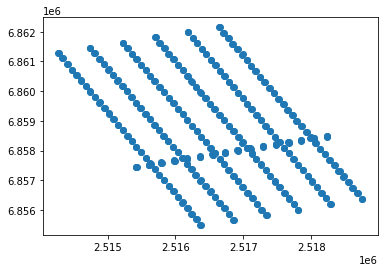

In [3]:
import time

def get_headers_in_dir(mydir: str) -> list:
    """
    Return header file paths in given directory (mydir)
    """
    ls = []
    for file in os.listdir(mydir):
        if file.endswith(".hdr"):
            ls.append(os.path.join(mydir, file))
    return ls

pan_headers = get_headers_in_dir('/media/markus/Ubuntu_Markus/Kuvat/Lvl2/PAN_HDR')
pan_headers[0]


res = []
for header_path in pan_headers:
    hdr1 = ImageHeader(header_path)
    hdr1.read_header()
    r = (hdr1.image_code, hdr1.x0, hdr1.y0)
    res.append(r)

imgc = pd.DataFrame(res, columns=['ImageCode', 'ImageX', 'ImageY'])
plt.scatter(imgc['ImageX'], imgc['ImageY'])

# Calculate image-pairs

In [4]:
triplets = pd.read_csv('triplets.csv')
imgc = pd.read_csv('image_pairs.csv') # 2 is with triples
imgc.shape

(192, 6)

In [5]:
sun_vals = pd.read_csv('sun_elevation_azimuth_2012.csv')
sun_vals
res = []
xs = []
ys = []
if imgc is None:
    for header_path in pan_headers:

        hdr1 = ImageHeader(header_path)
        hdr1.read_header()

        image_filename = hdr1.get_filename()
        splitted_name = image_filename.split('/')
        image_num = splitted_name[-2]

        vals = sun_vals[sun_vals['image_number'] == int(image_num)]
        elev1 = np.radians(vals.iloc[0]['sun_elevation'])
        cl = 30
        for header_path2 in pan_headers:
            hdr2 = ImageHeader(header_path2)
            hdr2.read_header()

            image_filename = hdr2.get_filename()
            splitted_name = image_filename.split('/')
            image_num = splitted_name[-2]

            vals = sun_vals[sun_vals['image_number'] == int(image_num)]
            elev2 = np.radians(vals.iloc[0]['sun_elevation'])
            dist = np.sqrt((hdr2.x0-hdr1.x0)**2 + (hdr2.y0-hdr1.y0)**2)
            el = np.degrees(elev1) - np.degrees(elev2)
            if dist != 0 and dist < 30 and el < 5 and el > 0:
                if hdr1.image_code != hdr2.image_code:
                    r = (hdr1.image_code,
                             hdr2.image_code,
                             el, np.degrees(elev1),
                            np.degrees(elev2))
                    res.append(r)
                    xs.append(hdr2.x0)
                    ys.append(hdr2.y0)

    imgc = pd.DataFrame(res, columns=['ImageCode1', 'ImageCode2', 'ElevationDiff', 'Elevation1', 'Elevation2'])
    # imgc = imgc.drop_duplicates(subset=['ImageCode1', 'ImageCode2'])
    imgc.to_csv('image_pairs2.csv')

    plt.scatter(xs, ys)
imgc

Unnamed: 0  ImageCode1  ImageCode2  ElevationDiff  Elevation1  Elevation2
0             0      310368      310160       4.229555   37.345547   33.115992
1             1      310360      310152       4.231822   37.308239   33.076416
2             2      510428      510220       4.115184   38.489328   34.374144
3             3      210321      210113       4.302171   36.667089   32.364919
4             4      110298      110090       4.277106   36.124604   31.847498
..          ...         ...         ...            ...         ...         ...
187         187      610473      610265       4.048918   39.123107   35.074189
188         188      210324      210116       4.301015   36.678680   32.377665
189         189      310383      310175       4.227119   37.416791   33.189673
190         190      610458      610250       4.055713   39.062472   35.006759
191         191      510424      510216       4.119137   38.472218   34.353081

[192 rows x 6 columns]

# Calculate pair_id for pairs and for triplets calculate start_end_total

In [6]:
def h(d):
    """
    Function that calculate images pairs in locations of 5 m distance
    """
    d = d.iloc[0:3]
    d = d.sort_values(by=['Elevation1'], ascending=True)
    
    d['start_end_total'] = np.arange(1, d.shape[0]+1, 1)
    d['start_end_total'] = str(0) + '-' + d['start_end_total'].astype(str) + '-' +str(d.shape[0])
    
    dsh = d.shape[0]
    
    if d.shape[0] > 1:
        for i in range(0, d.shape[0] - 1):
            cod2 = d.iloc[i]['ImageCode1']
            cod1 = d.iloc[i+1]['ImageCode1']
            res = pd.DataFrame({
                'ImageCode1': cod1,
                'ImageCode2': cod2,
                'start_end_total': str(i+1) + '-' + str(i+2) + '-' + str(dsh),
                'Elevation1': d.iloc[i+1]['Elevation1'],
                'Elevation2': d.iloc[i]['Elevation1'],
            }, index=[0])
            d = d.append(res)
            
    d['ElevationDiff'] = d['Elevation1'] - d['Elevation2']
    d['pair_id'] = str(d.iloc[0]['ImageCode1']) + '-' 't'
    return d
    
tr = imgc.groupby('ImageCode2').apply(h)
tr.shape

(192, 8)

# Calculate mean values for each band for groups of Serial, ImageCode and visibility

In [17]:
res = pnts.groupby(['Serial', 'ImageCode', 'visibility'])[['B', 'G', 'R', 'N', 'P']].mean()
res['B'] = res['B']  - (77 + 67)
res['G'] = res['G'] - (76 + 50)
res['R'] = res['R'] - (47 + 38) 
res['N'] = res['N'] -  (214 + 40)
res['P'] = res['P'] - (60 + 47)

res_r = pnts.groupby(['Serial', 'ImageCode', 'visibility'])[['B', 'G', 'R', 'N', 'P']].mean()
res_r['B'] = -0.0000425049286896378 + 0.000163000081936 * (res_r['B']  - (77 + 67))
res_r['G'] = 0.001870326708756 + 0.000145135211975 * (res_r['G'] - (76 + 50))
res_r['R'] = 0.007979164620919 + 0.000122451943818 * (res_r['R'] - (47 + 38))
res_r['N'] = 0.007021768141202 + 0.000129384723333 * (res_r['N'] -  (214 + 40))
res_r['P'] = 0.006927989981104 + 0.000147029925454 * (res_r['P'] - (60 + 35))
res_r

B         G         R         N  \
Serial ImageCode visibility                                              
1002   410191    self_shadowed  0.011866  0.023399  0.024531  0.184408   
                 sunlit         0.015019  0.028082  0.027584  0.194073   
       410192    self_shadowed  0.010909  0.024938  0.026607  0.179338   
                 sunlit         0.020586  0.039702  0.035681  0.229204   
       410193    self_shadowed  0.012985  0.025728  0.026799  0.192520   
...                                  ...       ...       ...       ...   
1696   510430    sunlit         0.017366  0.030462  0.029041  0.172155   
       510431    self_shadowed  0.008131  0.020012  0.017950  0.149585   
                 sunlit         0.014872  0.028067  0.024173  0.162785   
       510432    self_shadowed  0.010493  0.019933  0.019679  0.140476   
                 sunlit         0.013193  0.026659  0.023555  0.156616   

                                       P  
Serial ImageCode visibility               
1002   410191    self_shadowed  0.023861  
                 sunlit         0.037922  
       410192    self_shadowed  0.023542  
                 sunlit         0.046250  
       410193    self_shadowed  0.022264  
...                                  ...  
1696   510430    sunlit         0.033790  
       510431    self_shadowed  0.017220  
                 sunlit         0.032456  
       510432    self_shadowed  0.022727  
                 sunlit         0.034334  

[16998 rows x 5 columns]

# Calculating mean reflectances

In [8]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res_r.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res_r.loc[(i, row['ImageCode2'], 'sunlit'), :]
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = (vals1 + vals2) / 2
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res_r.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res_r.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            shadowb, shadowg, shadowr, shadown, shadowp = (vals1 + vals2) / 2
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
reflectances = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

# CHA.to_csv("PAIRS/ADD/ABSOLUTE_CHANGES_BY_TREES_PAIRS_ADD.csv")

In [18]:
reflectance = reflectances.loc[reflectances['Species'] == 4, 'Species'] = 3
r_sp = reflectances.groupby('Species')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()
np.round(r_sp, 3)

/tmp/ipykernel_22399/2653354626.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  r_sp = reflectances.groupby('Species')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()


SLB    SHB    SLG    SHG    SLR    SHR    SLN    SHN    SLP    SHP
Species                                                                      
1        0.022  0.016  0.044  0.031  0.037  0.028  0.236  0.186  0.046  0.030
2        0.015  0.010  0.034  0.022  0.030  0.022  0.201  0.157  0.038  0.022
3        0.024  0.015  0.047  0.032  0.041  0.029  0.300  0.228  0.049  0.031

# Calculate values for first image of pairs

In [10]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = vals2
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = vals2
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
pair_1 = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

# Calculate values for second image of pairs

In [11]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = vals1
            
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = vals1
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']
            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            continue
            
pair_2 = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

In [12]:
imgc = tr
results = []
serials = pnts['Serial'].unique()
for i in serials:
    species = pnts[pnts['Serial'] == i].iloc[0]['Plaji']
    for index, row in imgc.iterrows():
        try:
            el_diff = row['ElevationDiff']
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'sunlit'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'sunlit'), :]
            diff = vals1 - vals2
            print(vals1.values)
            print(vals2.values)
            print(diff.values)
            sunlitb, sunlitg, sunlitr, sunlitn, sunlitp = diff
            
            # ImageCode2 is taken first -> ImageCode1 after sun elevation increase
            vals1 = res.loc[(i, row['ImageCode1'], 'self_shadowed'), :]
            vals2 = res.loc[(i, row['ImageCode2'], 'self_shadowed'), :]
            diff = vals1 - vals2
            shadowb, shadowg, shadowr, shadown, shadowp = diff
            
            # Triplet or pair-id
            pair_id = str(i) + '-' + row['pair_id']

            
            q = (
                 species,
                 i,
                 sunlitb,
                 shadowb,
                 sunlitg,
                 shadowg,
                 sunlitr,
                 shadowr,
                 sunlitn,
                 shadown,
                 sunlitp,
                 shadowp,
                 row['ImageCode1'],
                 row['ImageCode2'],
                 row['start_end_total'],
                 pair_id,
                 row['ElevationDiff'],
                 row['Elevation1'],
                 row['Elevation2']
            )
            results.append(q)
        except Exception as e:
            print(e)
            continue
            
mean_diff = pd.DataFrame(results, columns=['Species',
                                     'Serial',
                                     'SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP',
                                     'ImageCode1','ImageCode2',
                                     'start_end_total',
                                     'pair_id',
                                     'ElevationDiff','Elevation1', 'Elevation2'])

(1002, 110288, 'sunlit')
(1002, 110289, 'sunlit')
(1002, 110290, 'sunlit')
(1002, 110291, 'sunlit')
(1002, 110292, 'sunlit')
(1002, 110293, 'sunlit')
(1002, 110294, 'sunlit')
(1002, 110295, 'sunlit')
(1002, 110296, 'sunlit')
(1002, 110297, 'sunlit')
(1002, 110298, 'sunlit')
(1002, 110299, 'sunlit')
(1002, 110300, 'sunlit')
(1002, 110301, 'sunlit')
(1002, 110302, 'sunlit')
(1002, 110303, 'sunlit')
(1002, 110304, 'sunlit')
(1002, 110305, 'sunlit')
(1002, 110306, 'sunlit')
(1002, 110307, 'sunlit')
(1002, 110308, 'sunlit')
(1002, 110309, 'sunlit')
(1002, 110310, 'sunlit')
(1002, 110311, 'sunlit')
(1002, 110312, 'sunlit')
(1002, 110313, 'sunlit')
(1002, 110314, 'sunlit')
(1002, 110315, 'sunlit')
(1002, 110316, 'sunlit')
(1002, 110317, 'sunlit')
(1002, 110318, 'sunlit')
(1002, 110319, 'sunlit')
(1002, 210320, 'sunlit')
(1002, 210321, 'sunlit')
(1002, 210322, 'sunlit')
(1002, 210323, 'sunlit')
(1002, 210324, 'sunlit')
(1002, 210325, 'sunlit')
(1002, 210326, 'sunlit')
(1002, 210327, 'sunlit')


(1007, 110288, 'sunlit')
(1007, 110289, 'sunlit')
(1007, 110290, 'sunlit')
(1007, 110291, 'sunlit')
(1007, 110292, 'sunlit')
(1007, 110293, 'sunlit')
(1007, 110294, 'sunlit')
(1007, 110295, 'sunlit')
(1007, 110296, 'sunlit')
(1007, 110297, 'sunlit')
(1007, 110298, 'sunlit')
(1007, 110299, 'sunlit')
(1007, 110300, 'sunlit')
(1007, 110301, 'sunlit')
(1007, 110302, 'sunlit')
(1007, 110303, 'sunlit')
(1007, 110304, 'sunlit')
(1007, 110305, 'sunlit')
(1007, 110306, 'sunlit')
(1007, 110307, 'sunlit')
(1007, 110308, 'sunlit')
(1007, 110309, 'sunlit')
(1007, 110310, 'sunlit')
(1007, 110311, 'sunlit')
(1007, 110312, 'sunlit')
(1007, 110313, 'sunlit')
(1007, 110314, 'sunlit')
(1007, 110315, 'sunlit')
(1007, 110316, 'sunlit')
(1007, 110317, 'sunlit')
(1007, 110318, 'sunlit')
(1007, 110319, 'sunlit')
(1007, 210320, 'sunlit')
(1007, 210321, 'sunlit')
(1007, 210322, 'sunlit')
(1007, 210323, 'sunlit')
(1007, 210324, 'sunlit')
(1007, 210325, 'sunlit')
(1007, 210326, 'sunlit')
(1007, 210327, 'sunlit')


(1011, 410398, 'sunlit')
[ 196.8  284.2  212.2 1647.4  230.8]
[ 197.75  258.    197.75 1581.    226.5 ]
[-0.95 26.2  14.45 66.4   4.3 ]
[ 238.66666667  353.16666667  268.83333333 1925.66666667  354.66666667]
[ 202.5   292.5   229.25 1678.    263.  ]
[ 36.16666667  60.66666667  39.58333333 247.66666667  91.66666667]
[ 279.          415.5         299.16666667 2181.33333333  400.33333333]
[ 212.5  267.5  206.  1624.   247. ]
[ 66.5        148.          93.16666667 557.33333333 153.33333333]
[ 298.5    470.625  332.75  2357.     421.125]
[ 228.4  288.2  194.6 1682.8  251.2]
[ 70.1   182.425 138.15  674.2   169.925]
[ 278.5         433.83333333  333.5        2305.          383.5       ]
[ 231.    312.5   249.25 1672.5   221.  ]
[ 47.5        121.33333333  84.25       632.5        162.5       ]
(1011, 410404, 'sunlit')
(1011, 410405, 'sunlit')
(1011, 410406, 'sunlit')
(1011, 410407, 'sunlit')
(1011, 410408, 'sunlit')
(1011, 410409, 'sunlit')
(1011, 410410, 'sunlit')
(1011, 410411, 'sunlit')


(1017, 110288, 'sunlit')
(1017, 110289, 'sunlit')
(1017, 110290, 'sunlit')
(1017, 110291, 'sunlit')
(1017, 110292, 'sunlit')
(1017, 110293, 'sunlit')
(1017, 110294, 'sunlit')
(1017, 110295, 'sunlit')
(1017, 110296, 'sunlit')
(1017, 110297, 'sunlit')
(1017, 110298, 'sunlit')
(1017, 110299, 'sunlit')
(1017, 110300, 'sunlit')
(1017, 110301, 'sunlit')
(1017, 110302, 'sunlit')
(1017, 110303, 'sunlit')
(1017, 110304, 'sunlit')
(1017, 110305, 'sunlit')
(1017, 110306, 'sunlit')
(1017, 110307, 'sunlit')
(1017, 110308, 'sunlit')
(1017, 110309, 'sunlit')
(1017, 110310, 'sunlit')
(1017, 110311, 'sunlit')
(1017, 110312, 'sunlit')
(1017, 110313, 'sunlit')
(1017, 110314, 'sunlit')
(1017, 110315, 'sunlit')
(1017, 110316, 'sunlit')
(1017, 110317, 'sunlit')
(1017, 110318, 'sunlit')
(1017, 110319, 'sunlit')
(1017, 210320, 'sunlit')
(1017, 210321, 'sunlit')
(1017, 210322, 'sunlit')
(1017, 210323, 'sunlit')
(1017, 210324, 'sunlit')
(1017, 210325, 'sunlit')
(1017, 210326, 'sunlit')
(1017, 210327, 'sunlit')


[ 343.76923077  505.61538462  423.92307692 2643.76923077  393.30769231]
[ 5.35576923 41.94711538 23.01442308 25.60576923 44.25480769]
(1023, 410404, 'sunlit')
(1023, 410405, 'sunlit')
(1023, 410406, 'sunlit')
(1023, 410407, 'sunlit')
(1023, 410408, 'sunlit')
(1023, 410409, 'sunlit')
(1023, 410410, 'sunlit')
(1023, 410411, 'sunlit')
(1023, 410412, 'sunlit')
(1023, 410413, 'sunlit')
(1023, 410414, 'sunlit')
(1023, 410415, 'sunlit')
(1023, 510416, 'sunlit')
(1023, 510417, 'sunlit')
(1023, 510418, 'sunlit')
(1023, 510419, 'sunlit')
(1023, 510420, 'sunlit')
(1023, 510421, 'sunlit')
(1023, 510422, 'sunlit')
(1023, 510423, 'sunlit')
(1023, 510424, 'sunlit')
(1023, 510425, 'sunlit')
(1023, 510426, 'sunlit')
(1023, 510427, 'sunlit')
(1023, 510428, 'sunlit')
[ 356.88235294  507.47058824  454.70588235 2334.94117647  427.94117647]
[ 305.04166667  485.79166667  374.54166667 2356.16666667  409.70833333]
[ 51.84068627  21.67892157  80.16421569 -21.2254902   18.23284314]
[ 333.75  471.8   405.4  2255.

(1033, 510441, 'sunlit')
(1033, 510442, 'sunlit')
(1033, 510443, 'sunlit')
(1033, 510444, 'sunlit')
(1033, 510445, 'sunlit')
(1033, 510446, 'sunlit')
(1033, 510447, 'sunlit')
(1033, 610448, 'sunlit')
(1033, 610449, 'sunlit')
(1033, 610450, 'sunlit')
(1033, 610451, 'sunlit')
(1033, 610452, 'sunlit')
(1033, 610453, 'sunlit')
(1033, 610454, 'sunlit')
(1033, 610455, 'sunlit')
(1033, 610456, 'sunlit')
(1033, 610457, 'sunlit')
(1033, 610458, 'sunlit')
(1033, 610459, 'sunlit')
(1033, 610460, 'sunlit')
(1033, 610461, 'sunlit')
(1033, 610462, 'sunlit')
(1033, 610463, 'sunlit')
(1033, 610464, 'sunlit')
(1033, 610465, 'sunlit')
(1033, 610466, 'sunlit')
(1033, 610467, 'sunlit')
(1033, 610468, 'sunlit')
(1033, 610469, 'sunlit')
(1033, 610470, 'sunlit')
(1033, 610471, 'sunlit')
(1033, 610472, 'sunlit')
(1033, 610473, 'sunlit')
(1033, 610474, 'sunlit')
(1033, 610475, 'sunlit')
(1033, 610476, 'sunlit')
(1033, 610477, 'sunlit')
(1033, 610478, 'sunlit')
(1033, 610479, 'sunlit')
(1035, 110288, 'sunlit')


(1042, 110288, 'sunlit')
(1042, 110289, 'sunlit')
(1042, 110290, 'sunlit')
(1042, 110291, 'sunlit')
(1042, 110292, 'sunlit')
(1042, 110293, 'sunlit')
(1042, 110294, 'sunlit')
(1042, 110295, 'sunlit')
(1042, 110296, 'sunlit')
(1042, 110297, 'sunlit')
(1042, 110298, 'sunlit')
(1042, 110299, 'sunlit')
(1042, 110300, 'sunlit')
(1042, 110301, 'sunlit')
(1042, 110302, 'sunlit')
(1042, 110303, 'sunlit')
(1042, 110304, 'sunlit')
(1042, 110305, 'sunlit')
(1042, 110306, 'sunlit')
(1042, 110307, 'sunlit')
(1042, 110308, 'sunlit')
(1042, 110309, 'sunlit')
(1042, 110310, 'sunlit')
(1042, 110311, 'sunlit')
(1042, 110312, 'sunlit')
(1042, 110313, 'sunlit')
(1042, 110314, 'sunlit')
(1042, 110315, 'sunlit')
(1042, 110316, 'sunlit')
(1042, 110317, 'sunlit')
(1042, 110318, 'sunlit')
(1042, 110319, 'sunlit')
(1042, 210320, 'sunlit')
(1042, 210321, 'sunlit')
(1042, 210322, 'sunlit')
(1042, 210323, 'sunlit')
(1042, 210324, 'sunlit')
(1042, 210325, 'sunlit')
(1042, 210326, 'sunlit')
(1042, 210327, 'sunlit')


(1047, 210335, 'sunlit')
(1047, 210336, 'sunlit')
(1047, 210337, 'sunlit')
(1047, 210338, 'sunlit')
(1047, 210339, 'sunlit')
(1047, 210340, 'sunlit')
(1047, 210341, 'sunlit')
(1047, 210342, 'sunlit')
(1047, 210343, 'sunlit')
(1047, 210344, 'sunlit')
(1047, 210345, 'sunlit')
(1047, 210346, 'sunlit')
(1047, 210347, 'sunlit')
(1047, 210348, 'sunlit')
(1047, 210349, 'sunlit')
(1047, 210350, 'sunlit')
(1047, 210351, 'sunlit')
(1047, 310352, 'sunlit')
(1047, 310353, 'sunlit')
(1047, 310354, 'sunlit')
(1047, 310355, 'sunlit')
(1047, 310356, 'sunlit')
(1047, 310357, 'sunlit')
(1047, 310358, 'sunlit')
(1047, 310359, 'sunlit')
(1047, 310360, 'sunlit')
(1047, 310361, 'sunlit')
(1047, 310362, 'sunlit')
(1047, 310363, 'sunlit')
(1047, 310364, 'sunlit')
(1047, 310365, 'sunlit')
(1047, 310366, 'sunlit')
(1047, 310367, 'sunlit')
(1047, 310368, 'sunlit')
(1047, 310369, 'sunlit')
(1047, 310370, 'sunlit')
(1047, 310371, 'sunlit')
(1047, 310372, 'sunlit')
(1047, 310373, 'sunlit')
(1047, 310374, 'sunlit')


(1051, 610465, 'sunlit')
(1051, 610466, 'sunlit')
(1051, 610467, 'sunlit')
(1051, 610468, 'sunlit')
(1051, 610469, 'sunlit')
(1051, 610470, 'sunlit')
(1051, 610471, 'sunlit')
(1051, 610472, 'sunlit')
(1051, 610473, 'sunlit')
(1051, 610474, 'sunlit')
(1051, 610475, 'sunlit')
(1051, 610476, 'sunlit')
(1051, 610477, 'sunlit')
(1051, 610478, 'sunlit')
(1051, 610479, 'sunlit')
(1052, 110288, 'sunlit')
(1052, 110289, 'sunlit')
(1052, 110290, 'sunlit')
(1052, 110291, 'sunlit')
(1052, 110292, 'sunlit')
(1052, 110293, 'sunlit')
(1052, 110294, 'sunlit')
(1052, 110295, 'sunlit')
(1052, 110296, 'sunlit')
(1052, 110297, 'sunlit')
(1052, 110298, 'sunlit')
(1052, 110299, 'sunlit')
(1052, 110300, 'sunlit')
(1052, 110301, 'sunlit')
(1052, 110302, 'sunlit')
(1052, 110303, 'sunlit')
(1052, 110304, 'sunlit')
(1052, 110305, 'sunlit')
(1052, 110306, 'sunlit')
(1052, 110307, 'sunlit')
(1052, 110308, 'sunlit')
(1052, 110309, 'sunlit')
(1052, 110310, 'sunlit')
(1052, 110311, 'sunlit')
(1052, 110312, 'sunlit')


(1057, 110288, 'sunlit')
(1057, 110289, 'sunlit')
(1057, 110290, 'sunlit')
(1057, 110291, 'sunlit')
(1057, 110292, 'sunlit')
(1057, 110293, 'sunlit')
(1057, 110294, 'sunlit')
(1057, 110295, 'sunlit')
(1057, 110296, 'sunlit')
(1057, 110297, 'sunlit')
(1057, 110298, 'sunlit')
(1057, 110299, 'sunlit')
(1057, 110300, 'sunlit')
(1057, 110301, 'sunlit')
(1057, 110302, 'sunlit')
(1057, 110303, 'sunlit')
(1057, 110304, 'sunlit')
(1057, 110305, 'sunlit')
(1057, 110306, 'sunlit')
(1057, 110307, 'sunlit')
(1057, 110308, 'sunlit')
(1057, 110309, 'sunlit')
(1057, 110310, 'sunlit')
(1057, 110311, 'sunlit')
(1057, 110312, 'sunlit')
(1057, 110313, 'sunlit')
(1057, 110314, 'sunlit')
(1057, 110315, 'sunlit')
(1057, 110316, 'sunlit')
(1057, 110317, 'sunlit')
(1057, 110318, 'sunlit')
(1057, 110319, 'sunlit')
(1057, 210320, 'sunlit')
(1057, 210321, 'sunlit')
(1057, 210322, 'sunlit')
(1057, 210323, 'sunlit')
(1057, 210324, 'sunlit')
(1057, 210325, 'sunlit')
(1057, 210326, 'sunlit')
(1057, 210327, 'sunlit')


[ 172.25  217.5   150.   1098.75  238.  ]
[ 183.    232.75  168.75 1240.    270.  ]
[ -10.75  -15.25  -18.75 -141.25  -32.  ]
[ 210.83333333  292.66666667  206.66666667 1471.          255.33333333]
[ 211.83333333  275.          209.5        1506.66666667  253.33333333]
[ -1.          17.66666667  -2.83333333 -35.66666667   2.        ]
[ 243.5         354.66666667  252.33333333 1633.          277.33333333]
[ 222.75   278.5    194.75  1450.     267.125]
[ 20.75        76.16666667  57.58333333 183.          10.20833333]
[ 254.     367.625  293.625 1673.75   293.625]
[ 239.3  312.8  248.1 1525.   269.9]
[ 14.7    54.825  45.525 148.75   23.725]
(1062, 410404, 'sunlit')
(1062, 410405, 'sunlit')
(1062, 410406, 'sunlit')
(1062, 410407, 'sunlit')
(1062, 410408, 'sunlit')
(1062, 410409, 'sunlit')
(1062, 410410, 'sunlit')
(1062, 410411, 'sunlit')
(1062, 410412, 'sunlit')
(1062, 410413, 'sunlit')
(1062, 410414, 'sunlit')
(1062, 410415, 'sunlit')
(1062, 510416, 'sunlit')
(1062, 510417, 'sunlit')
(

[11.          5.33333333 -3.          6.          5.        ]
[162.   175.   114.25 908.25 157.5 ]
[147.4 162.8 117.  862.4 136.4]
[14.6  12.2  -2.75 45.85 21.1 ]
[173.   187.25 120.   928.5  145.  ]
[171.  166.6 104.6 832.  129. ]
[ 2.   20.65 15.4  96.5  16.  ]
[ 189.375  220.75   167.875 1103.25   179.125]
[171.5        174.33333333 116.16666667 845.5        128.83333333]
[ 17.875       46.41666667  51.70833333 257.75        50.29166667]
(1066, 410404, 'sunlit')
(1066, 410405, 'sunlit')
(1066, 410406, 'sunlit')
(1066, 410407, 'sunlit')
(1066, 410408, 'sunlit')
(1066, 410409, 'sunlit')
(1066, 410410, 'sunlit')
(1066, 410411, 'sunlit')
(1066, 410412, 'sunlit')
(1066, 410413, 'sunlit')
(1066, 410414, 'sunlit')
(1066, 410415, 'sunlit')
(1066, 510416, 'sunlit')
(1066, 510417, 'sunlit')
(1066, 510418, 'sunlit')
(1066, 510419, 'sunlit')
(1066, 510420, 'sunlit')
(1066, 510421, 'sunlit')
(1066, 510422, 'sunlit')
(1066, 510423, 'sunlit')
(1066, 510424, 'sunlit')
(1066, 510425, 'sunlit')
(1066

(1072, 110288, 'sunlit')
(1072, 110289, 'sunlit')
(1072, 110290, 'sunlit')
(1072, 110291, 'sunlit')
(1072, 110292, 'sunlit')
(1072, 110293, 'sunlit')
(1072, 110294, 'sunlit')
(1072, 110295, 'sunlit')
(1072, 110296, 'sunlit')
(1072, 110297, 'sunlit')
(1072, 110298, 'sunlit')
(1072, 110299, 'sunlit')
(1072, 110300, 'sunlit')
(1072, 110301, 'sunlit')
(1072, 110302, 'sunlit')
(1072, 110303, 'sunlit')
(1072, 110304, 'sunlit')
(1072, 110305, 'sunlit')
(1072, 110306, 'sunlit')
(1072, 110307, 'sunlit')
(1072, 110308, 'sunlit')
(1072, 110309, 'sunlit')
(1072, 110310, 'sunlit')
(1072, 110311, 'sunlit')
(1072, 110312, 'sunlit')
(1072, 110313, 'sunlit')
(1072, 110314, 'sunlit')
(1072, 110315, 'sunlit')
(1072, 110316, 'sunlit')
(1072, 110317, 'sunlit')
(1072, 110318, 'sunlit')
(1072, 110319, 'sunlit')
(1072, 210320, 'sunlit')
(1072, 210321, 'sunlit')
(1072, 210322, 'sunlit')
(1072, 210323, 'sunlit')
(1072, 210324, 'sunlit')
(1072, 210325, 'sunlit')
(1072, 210326, 'sunlit')
(1072, 210327, 'sunlit')


(1075, 510435, 'sunlit')
(1075, 510436, 'sunlit')
(1075, 510437, 'sunlit')
(1075, 510438, 'sunlit')
(1075, 510439, 'sunlit')
(1075, 510440, 'sunlit')
(1075, 510441, 'sunlit')
(1075, 510442, 'sunlit')
(1075, 510443, 'sunlit')
(1075, 510444, 'sunlit')
(1075, 510445, 'sunlit')
(1075, 510446, 'sunlit')
(1075, 510447, 'sunlit')
(1075, 610448, 'sunlit')
(1075, 610449, 'sunlit')
(1075, 610450, 'sunlit')
(1075, 610451, 'sunlit')
(1075, 610452, 'sunlit')
(1075, 610453, 'sunlit')
(1075, 610454, 'sunlit')
(1075, 610455, 'sunlit')
(1075, 610456, 'sunlit')
(1075, 610457, 'sunlit')
(1075, 610458, 'sunlit')
(1075, 610459, 'sunlit')
(1075, 610460, 'sunlit')
(1075, 610461, 'sunlit')
(1075, 610462, 'sunlit')
(1075, 610463, 'sunlit')
(1075, 610464, 'sunlit')
(1075, 610465, 'sunlit')
(1075, 610466, 'sunlit')
(1075, 610467, 'sunlit')
(1075, 610468, 'sunlit')
(1075, 610469, 'sunlit')
(1075, 610470, 'sunlit')
(1075, 610471, 'sunlit')
(1075, 610472, 'sunlit')
(1075, 610473, 'sunlit')
(1075, 610474, 'sunlit')


(1081, 110288, 'sunlit')
(1081, 110289, 'sunlit')
(1081, 110290, 'sunlit')
(1081, 110291, 'sunlit')
(1081, 110292, 'sunlit')
(1081, 110293, 'sunlit')
(1081, 110294, 'sunlit')
(1081, 110295, 'sunlit')
(1081, 110296, 'sunlit')
(1081, 110297, 'sunlit')
(1081, 110298, 'sunlit')
(1081, 110299, 'sunlit')
(1081, 110300, 'sunlit')
(1081, 110301, 'sunlit')
(1081, 110302, 'sunlit')
(1081, 110303, 'sunlit')
(1081, 110304, 'sunlit')
(1081, 110305, 'sunlit')
(1081, 110306, 'sunlit')
(1081, 110307, 'sunlit')
(1081, 110308, 'sunlit')
(1081, 110309, 'sunlit')
(1081, 110310, 'sunlit')
(1081, 110311, 'sunlit')
(1081, 110312, 'sunlit')
(1081, 110313, 'sunlit')
(1081, 110314, 'sunlit')
(1081, 110315, 'sunlit')
(1081, 110316, 'sunlit')
(1081, 110317, 'sunlit')
(1081, 110318, 'sunlit')
(1081, 110319, 'sunlit')
(1081, 210320, 'sunlit')
(1081, 210321, 'sunlit')
(1081, 210322, 'sunlit')
(1081, 210323, 'sunlit')
(1081, 210324, 'sunlit')
(1081, 210325, 'sunlit')
(1081, 210326, 'sunlit')
(1081, 210327, 'sunlit')


[ 286.85714286  415.92857143  346.14285714 1823.          419.        ]
[ 245.36363636  326.81818182  260.90909091 1490.81818182  282.        ]
[ 41.49350649  89.11038961  85.23376623 332.18181818 137.        ]
(1085, 410404, 'sunlit')
(1085, 410405, 'sunlit')
(1085, 410406, 'sunlit')
(1085, 410407, 'sunlit')
(1085, 410408, 'sunlit')
(1085, 410409, 'sunlit')
(1085, 410410, 'sunlit')
(1085, 410411, 'sunlit')
(1085, 410412, 'sunlit')
(1085, 410413, 'sunlit')
(1085, 410414, 'sunlit')
(1085, 410415, 'sunlit')
(1085, 510416, 'sunlit')
(1085, 510417, 'sunlit')
(1085, 510418, 'sunlit')
(1085, 510419, 'sunlit')
(1085, 510420, 'sunlit')
(1085, 510421, 'sunlit')
(1085, 510422, 'sunlit')
(1085, 510423, 'sunlit')
(1085, 510424, 'sunlit')
(1085, 510425, 'sunlit')
(1085, 510426, 'sunlit')
(1085, 510427, 'sunlit')
(1085, 510428, 'sunlit')
[ 349.58333333  481.91666667  449.         1872.75        468.5       ]
[ 279.25        417.          328.16666667 1682.          355.25      ]
[ 70.33333333  64.91

(1091, 110288, 'sunlit')
(1091, 110289, 'sunlit')
(1091, 110290, 'sunlit')
(1091, 110291, 'sunlit')
(1091, 110292, 'sunlit')
(1091, 110293, 'sunlit')
(1091, 110294, 'sunlit')
(1091, 110295, 'sunlit')
(1091, 110296, 'sunlit')
(1091, 110297, 'sunlit')
(1091, 110298, 'sunlit')
(1091, 110299, 'sunlit')
(1091, 110300, 'sunlit')
(1091, 110301, 'sunlit')
(1091, 110302, 'sunlit')
(1091, 110303, 'sunlit')
(1091, 110304, 'sunlit')
(1091, 110305, 'sunlit')
(1091, 110306, 'sunlit')
(1091, 110307, 'sunlit')
(1091, 110308, 'sunlit')
(1091, 110309, 'sunlit')
(1091, 110310, 'sunlit')
(1091, 110311, 'sunlit')
(1091, 110312, 'sunlit')
(1091, 110313, 'sunlit')
(1091, 110314, 'sunlit')
(1091, 110315, 'sunlit')
(1091, 110316, 'sunlit')
(1091, 110317, 'sunlit')
(1091, 110318, 'sunlit')
(1091, 110319, 'sunlit')
(1091, 210320, 'sunlit')
(1091, 210321, 'sunlit')
(1091, 210322, 'sunlit')
(1091, 210323, 'sunlit')
(1091, 210324, 'sunlit')
(1091, 210325, 'sunlit')
(1091, 210326, 'sunlit')
(1091, 210327, 'sunlit')


(1096, 410412, 'sunlit')
(1096, 410413, 'sunlit')
(1096, 410414, 'sunlit')
(1096, 410415, 'sunlit')
(1096, 510416, 'sunlit')
(1096, 510417, 'sunlit')
(1096, 510418, 'sunlit')
(1096, 510419, 'sunlit')
(1096, 510420, 'sunlit')
(1096, 510421, 'sunlit')
(1096, 510422, 'sunlit')
(1096, 510423, 'sunlit')
(1096, 510424, 'sunlit')
(1096, 510425, 'sunlit')
(1096, 510426, 'sunlit')
(1096, 510427, 'sunlit')
(1096, 510428, 'sunlit')
[ 326.95833333  511.25        443.75       2390.91666667  430.        ]
[ 258.15  441.5   326.65 2239.75  367.25]
[ 68.80833333  69.75       117.1        151.16666667  62.75      ]
[ 309.76470588  492.23529412  406.58823529 2412.47058824  408.88235294]
[ 270.21052632  427.31578947  304.89473684 2229.89473684  358.94736842]
[ 39.55417957  64.91950464 101.69349845 182.57585139  49.93498452]
[ 265.8         436.26666667  308.73333333 2128.66666667  355.13333333]
[ 244.25    367.25    278.5    1988.3125  322.    ]
[ 21.55        69.01666667  30.23333333 140.35416667  33.13

(1101, 110288, 'sunlit')
(1101, 110289, 'sunlit')
(1101, 110290, 'sunlit')
(1101, 110291, 'sunlit')
(1101, 110292, 'sunlit')
(1101, 110293, 'sunlit')
(1101, 110294, 'sunlit')
(1101, 110295, 'sunlit')
(1101, 110296, 'sunlit')
(1101, 110297, 'sunlit')
(1101, 110298, 'sunlit')
(1101, 110299, 'sunlit')
(1101, 110300, 'sunlit')
(1101, 110301, 'sunlit')
(1101, 110302, 'sunlit')
(1101, 110303, 'sunlit')
(1101, 110304, 'sunlit')
(1101, 110305, 'sunlit')
(1101, 110306, 'sunlit')
(1101, 110307, 'sunlit')
(1101, 110308, 'sunlit')
(1101, 110309, 'sunlit')
(1101, 110310, 'sunlit')
(1101, 110311, 'sunlit')
(1101, 110312, 'sunlit')
(1101, 110313, 'sunlit')
(1101, 110314, 'sunlit')
(1101, 110315, 'sunlit')
(1101, 110316, 'sunlit')
(1101, 110317, 'sunlit')
(1101, 110318, 'sunlit')
(1101, 110319, 'sunlit')
(1101, 210320, 'sunlit')
(1101, 210321, 'sunlit')
(1101, 210322, 'sunlit')
(1101, 210323, 'sunlit')
(1101, 210324, 'sunlit')
(1101, 210325, 'sunlit')
(1101, 210326, 'sunlit')
(1101, 210327, 'sunlit')


(1105, 310375, 'sunlit')
(1105, 310376, 'sunlit')
(1105, 310377, 'sunlit')
(1105, 310378, 'sunlit')
(1105, 310379, 'sunlit')
(1105, 310380, 'sunlit')
(1105, 310381, 'sunlit')
(1105, 310382, 'sunlit')
(1105, 310383, 'sunlit')
(1105, 410384, 'sunlit')
(1105, 410385, 'sunlit')
(1105, 410386, 'sunlit')
(1105, 410387, 'sunlit')
(1105, 410388, 'sunlit')
(1105, 410389, 'sunlit')
(1105, 410390, 'sunlit')
(1105, 410391, 'sunlit')
(1105, 410392, 'sunlit')
(1105, 410393, 'sunlit')
(1105, 410394, 'sunlit')
(1105, 410395, 'sunlit')
(1105, 410396, 'sunlit')
(1105, 410397, 'sunlit')
(1105, 410398, 'sunlit')
[ 218.25  302.5   214.5  1552.    327.5 ]
[ 213.42857143  261.71428571  193.14285714 1608.14285714  284.85714286]
[  4.82142857  40.78571429  21.35714286 -56.14285714  42.64285714]
[ 263.          344.33333333  253.66666667 1792.83333333  378.33333333]
[ 233.5         306.33333333  237.16666667 1738.66666667  323.66666667]
[29.5        38.         16.5        54.16666667 54.66666667]
[ 263.125  37

(1109, 110294, 'sunlit')
(1109, 110295, 'sunlit')
(1109, 110296, 'sunlit')
(1109, 110297, 'sunlit')
(1109, 110298, 'sunlit')
(1109, 110299, 'sunlit')
(1109, 110300, 'sunlit')
(1109, 110301, 'sunlit')
(1109, 110302, 'sunlit')
(1109, 110303, 'sunlit')
(1109, 110304, 'sunlit')
(1109, 110305, 'sunlit')
(1109, 110306, 'sunlit')
(1109, 110307, 'sunlit')
(1109, 110308, 'sunlit')
(1109, 110309, 'sunlit')
(1109, 110310, 'sunlit')
(1109, 110311, 'sunlit')
(1109, 110312, 'sunlit')
(1109, 110313, 'sunlit')
(1109, 110314, 'sunlit')
(1109, 110315, 'sunlit')
(1109, 110316, 'sunlit')
(1109, 110317, 'sunlit')
(1109, 110318, 'sunlit')
(1109, 110319, 'sunlit')
(1109, 210320, 'sunlit')
(1109, 210321, 'sunlit')
(1109, 210322, 'sunlit')
(1109, 210323, 'sunlit')
(1109, 210324, 'sunlit')
(1109, 210325, 'sunlit')
(1109, 210326, 'sunlit')
(1109, 210327, 'sunlit')
(1109, 210328, 'sunlit')
(1109, 210329, 'sunlit')
(1109, 210330, 'sunlit')
(1109, 210331, 'sunlit')
(1109, 210332, 'sunlit')
(1109, 210333, 'sunlit')


[ 247.2  376.2  263.9 1925.3  342.3]
[ 255.07692308  386.23076923  293.61538462 2170.07692308  328.84615385]
[  -7.87692308  -10.03076923  -29.71538462 -244.77692308   13.45384615]
(1114, 510432, 'sunlit')
(1114, 510433, 'sunlit')
(1114, 510434, 'sunlit')
(1114, 510435, 'sunlit')
(1114, 510436, 'sunlit')
(1114, 510437, 'sunlit')
(1114, 510438, 'sunlit')
(1114, 510439, 'sunlit')
(1114, 510440, 'sunlit')
(1114, 510441, 'sunlit')
(1114, 510442, 'sunlit')
(1114, 510443, 'sunlit')
(1114, 510444, 'sunlit')
(1114, 510445, 'sunlit')
(1114, 510446, 'sunlit')
(1114, 510447, 'sunlit')
(1114, 610448, 'sunlit')
(1114, 610449, 'sunlit')
(1114, 610450, 'sunlit')
(1114, 610451, 'sunlit')
(1114, 610452, 'sunlit')
(1114, 610453, 'sunlit')
(1114, 610454, 'sunlit')
(1114, 610455, 'sunlit')
(1114, 610456, 'sunlit')
(1114, 610457, 'sunlit')
(1114, 610458, 'sunlit')
(1114, 610459, 'sunlit')
(1114, 610460, 'sunlit')
(1114, 610461, 'sunlit')
(1114, 610462, 'sunlit')
(1114, 610463, 'sunlit')
(1114, 610464, 'sun

(1119, 410398, 'sunlit')
[ 171.83333333  237.          171.         1413.66666667  192.5       ]
[ 206.55555556  281.66666667  220.22222222 1725.55555556  241.88888889]
[ -34.72222222  -44.66666667  -49.22222222 -311.88888889  -49.38888889]
[ 194.33333333  267.          201.16666667 1524.16666667  229.5       ]
[ 196.85714286  291.71428571  222.71428571 1764.42857143  232.14285714]
[  -2.52380952  -24.71428571  -21.54761905 -240.26190476   -2.64285714]
[ 215.66666667  326.55555556  223.66666667 1740.11111111  318.44444444]
[ 223.44444444  329.22222222  259.         1941.22222222  303.        ]
[  -7.77777778   -2.66666667  -35.33333333 -201.11111111   15.44444444]
[ 247.5         372.33333333  260.5        1854.83333333  329.16666667]
[ 240.66666667  334.58333333  237.         1924.91666667  295.41666667]
[  6.83333333  37.75        23.5        -70.08333333  33.75      ]
[ 261.58823529  408.          317.35294118 1957.58823529  361.52941176]
[ 238.64705882  341.82352941  273.52941176 1

(1126, 110310, 'sunlit')
(1126, 110311, 'sunlit')
(1126, 110312, 'sunlit')
(1126, 110313, 'sunlit')
(1126, 110314, 'sunlit')
(1126, 110315, 'sunlit')
(1126, 110316, 'sunlit')
(1126, 110317, 'sunlit')
(1126, 110318, 'sunlit')
(1126, 110319, 'sunlit')
(1126, 210320, 'sunlit')
(1126, 210321, 'sunlit')
(1126, 210322, 'sunlit')
(1126, 210323, 'sunlit')
(1126, 210324, 'sunlit')
(1126, 210325, 'sunlit')
(1126, 210326, 'sunlit')
(1126, 210327, 'sunlit')
(1126, 210328, 'sunlit')
(1126, 210329, 'sunlit')
(1126, 210330, 'sunlit')
(1126, 210331, 'sunlit')
(1126, 210332, 'sunlit')
(1126, 210333, 'sunlit')
(1126, 210334, 'sunlit')
(1126, 210335, 'sunlit')
(1126, 210336, 'sunlit')
(1126, 210337, 'sunlit')
(1126, 210338, 'sunlit')
(1126, 210339, 'sunlit')
(1126, 210340, 'sunlit')
(1126, 210341, 'sunlit')
(1126, 210342, 'sunlit')
(1126, 210343, 'sunlit')
(1126, 210344, 'sunlit')
(1126, 210345, 'sunlit')
(1126, 210346, 'sunlit')
(1126, 210347, 'sunlit')
(1126, 210348, 'sunlit')
(1126, 210349, 'sunlit')


[ 240.14285714  365.28571429  260.42857143 2048.28571429  303.85714286]
[ 223.4  299.1  220.6 1936.4  249.3]
[ 16.74285714  66.18571429  39.82857143 111.88571429  54.55714286]
(1131, 510432, 'sunlit')
(1131, 510433, 'sunlit')
(1131, 510434, 'sunlit')
(1131, 510435, 'sunlit')
(1131, 510436, 'sunlit')
(1131, 510437, 'sunlit')
(1131, 510438, 'sunlit')
(1131, 510439, 'sunlit')
(1131, 510440, 'sunlit')
(1131, 510441, 'sunlit')
(1131, 510442, 'sunlit')
(1131, 510443, 'sunlit')
(1131, 510444, 'sunlit')
(1131, 510445, 'sunlit')
(1131, 510446, 'sunlit')
(1131, 510447, 'sunlit')
(1131, 610448, 'sunlit')
(1131, 610449, 'sunlit')
(1131, 610450, 'sunlit')
(1131, 610451, 'sunlit')
(1131, 610452, 'sunlit')
(1131, 610453, 'sunlit')
(1131, 610454, 'sunlit')
(1131, 610455, 'sunlit')
(1131, 610456, 'sunlit')
(1131, 610457, 'sunlit')
(1131, 610458, 'sunlit')
(1131, 610459, 'sunlit')
(1131, 610460, 'sunlit')
(1131, 610461, 'sunlit')
(1131, 610462, 'sunlit')
(1131, 610463, 'sunlit')
(1131, 610464, 'sunlit')

(1139, 310370, 'sunlit')
(1139, 310371, 'sunlit')
(1139, 310372, 'sunlit')
(1139, 310373, 'sunlit')
(1139, 310374, 'sunlit')
(1139, 310375, 'sunlit')
(1139, 310376, 'sunlit')
(1139, 310377, 'sunlit')
(1139, 310378, 'sunlit')
(1139, 310379, 'sunlit')
(1139, 310380, 'sunlit')
(1139, 310381, 'sunlit')
(1139, 310382, 'sunlit')
(1139, 310383, 'sunlit')
(1139, 410384, 'sunlit')
(1139, 410385, 'sunlit')
(1139, 410386, 'sunlit')
(1139, 410387, 'sunlit')
(1139, 410388, 'sunlit')
(1139, 410389, 'sunlit')
(1139, 410390, 'sunlit')
(1139, 410391, 'sunlit')
(1139, 410392, 'sunlit')
(1139, 410393, 'sunlit')
(1139, 410394, 'sunlit')
(1139, 410395, 'sunlit')
(1139, 410396, 'sunlit')
(1139, 410397, 'sunlit')
(1139, 410398, 'sunlit')
[ 152.85714286  208.14285714  144.71428571 1263.28571429  199.57142857]
[ 180.     215.375  159.    1415.25   194.25 ]
[ -27.14285714   -7.23214286  -14.28571429 -151.96428571    5.32142857]
[ 210.5         300.16666667  220.83333333 1654.83333333  272.5       ]
[ 191.   254

[ -8.68907563  33.95798319  28.94117647 -95.73109244  17.23529412]
[ 332.95  581.15  480.9  2717.6   475.9 ]
[ 298.          467.77777778  396.88888889 2340.77777778  385.05555556]
[ 34.95       113.37222222  84.01111111 376.82222222  90.84444444]
(1146, 410404, 'sunlit')
(1146, 410405, 'sunlit')
(1146, 410406, 'sunlit')
(1146, 410407, 'sunlit')
(1146, 410408, 'sunlit')
(1146, 410409, 'sunlit')
(1146, 410410, 'sunlit')
(1146, 410411, 'sunlit')
(1146, 410412, 'sunlit')
(1146, 410413, 'sunlit')
(1146, 410414, 'sunlit')
(1146, 410415, 'sunlit')
(1146, 510416, 'sunlit')
(1146, 510417, 'sunlit')
(1146, 510418, 'sunlit')
(1146, 510419, 'sunlit')
(1146, 510420, 'sunlit')
(1146, 510421, 'sunlit')
(1146, 510422, 'sunlit')
(1146, 510423, 'sunlit')
(1146, 510424, 'sunlit')
(1146, 510425, 'sunlit')
(1146, 510426, 'sunlit')
(1146, 510427, 'sunlit')
(1146, 510428, 'sunlit')
[ 325.04545455  507.5         442.         2337.09090909  441.        ]
[ 286.2962963   506.22222222  390.33333333 2461.2592592

(1155, 110288, 'sunlit')
(1155, 110289, 'sunlit')
(1155, 110290, 'sunlit')
(1155, 110291, 'sunlit')
(1155, 110292, 'sunlit')
(1155, 110293, 'sunlit')
(1155, 110294, 'sunlit')
(1155, 110295, 'sunlit')
(1155, 110296, 'sunlit')
(1155, 110297, 'sunlit')
(1155, 110298, 'sunlit')
(1155, 110299, 'sunlit')
(1155, 110300, 'sunlit')
(1155, 110301, 'sunlit')
(1155, 110302, 'sunlit')
(1155, 110303, 'sunlit')
(1155, 110304, 'sunlit')
(1155, 110305, 'sunlit')
(1155, 110306, 'sunlit')
(1155, 110307, 'sunlit')
(1155, 110308, 'sunlit')
(1155, 110309, 'sunlit')
(1155, 110310, 'sunlit')
(1155, 110311, 'sunlit')
(1155, 110312, 'sunlit')
(1155, 110313, 'sunlit')
(1155, 110314, 'sunlit')
(1155, 110315, 'sunlit')
(1155, 110316, 'sunlit')
(1155, 110317, 'sunlit')
(1155, 110318, 'sunlit')
(1155, 110319, 'sunlit')
(1155, 210320, 'sunlit')
(1155, 210321, 'sunlit')
(1155, 210322, 'sunlit')
(1155, 210323, 'sunlit')
(1155, 210324, 'sunlit')
(1155, 210325, 'sunlit')
(1155, 210326, 'sunlit')
(1155, 210327, 'sunlit')


(1162, 110288, 'sunlit')
(1162, 110289, 'sunlit')
(1162, 110290, 'sunlit')
(1162, 110291, 'sunlit')
(1162, 110292, 'sunlit')
(1162, 110293, 'sunlit')
(1162, 110294, 'sunlit')
(1162, 110295, 'sunlit')
(1162, 110296, 'sunlit')
(1162, 110297, 'sunlit')
(1162, 110298, 'sunlit')
(1162, 110299, 'sunlit')
(1162, 110300, 'sunlit')
(1162, 110301, 'sunlit')
(1162, 110302, 'sunlit')
(1162, 110303, 'sunlit')
(1162, 110304, 'sunlit')
(1162, 110305, 'sunlit')
(1162, 110306, 'sunlit')
(1162, 110307, 'sunlit')
(1162, 110308, 'sunlit')
(1162, 110309, 'sunlit')
(1162, 110310, 'sunlit')
(1162, 110311, 'sunlit')
(1162, 110312, 'sunlit')
(1162, 110313, 'sunlit')
(1162, 110314, 'sunlit')
(1162, 110315, 'sunlit')
(1162, 110316, 'sunlit')
(1162, 110317, 'sunlit')
(1162, 110318, 'sunlit')
(1162, 110319, 'sunlit')
(1162, 210320, 'sunlit')
(1162, 210321, 'sunlit')
(1162, 210322, 'sunlit')
(1162, 210323, 'sunlit')
(1162, 210324, 'sunlit')
(1162, 210325, 'sunlit')
(1162, 210326, 'sunlit')
(1162, 210327, 'sunlit')


(1167, 110306, 'sunlit')
(1167, 110307, 'sunlit')
(1167, 110308, 'sunlit')
(1167, 110309, 'sunlit')
(1167, 110310, 'sunlit')
(1167, 110311, 'sunlit')
(1167, 110312, 'sunlit')
(1167, 110313, 'sunlit')
(1167, 110314, 'sunlit')
(1167, 110315, 'sunlit')
(1167, 110316, 'sunlit')
(1167, 110317, 'sunlit')
(1167, 110318, 'sunlit')
(1167, 110319, 'sunlit')
(1167, 210320, 'sunlit')
(1167, 210321, 'sunlit')
(1167, 210322, 'sunlit')
(1167, 210323, 'sunlit')
(1167, 210324, 'sunlit')
(1167, 210325, 'sunlit')
(1167, 210326, 'sunlit')
(1167, 210327, 'sunlit')
(1167, 210328, 'sunlit')
(1167, 210329, 'sunlit')
(1167, 210330, 'sunlit')
(1167, 210331, 'sunlit')
(1167, 210332, 'sunlit')
(1167, 210333, 'sunlit')
(1167, 210334, 'sunlit')
(1167, 210335, 'sunlit')
(1167, 210336, 'sunlit')
(1167, 210337, 'sunlit')
(1167, 210338, 'sunlit')
(1167, 210339, 'sunlit')
(1167, 210340, 'sunlit')
(1167, 210341, 'sunlit')
(1167, 210342, 'sunlit')
(1167, 210343, 'sunlit')
(1167, 210344, 'sunlit')
(1167, 210345, 'sunlit')


(1172, 110288, 'sunlit')
(1172, 110289, 'sunlit')
(1172, 110290, 'sunlit')
(1172, 110291, 'sunlit')
(1172, 110292, 'sunlit')
(1172, 110293, 'sunlit')
(1172, 110294, 'sunlit')
(1172, 110295, 'sunlit')
(1172, 110296, 'sunlit')
(1172, 110297, 'sunlit')
(1172, 110298, 'sunlit')
(1172, 110299, 'sunlit')
(1172, 110300, 'sunlit')
(1172, 110301, 'sunlit')
(1172, 110302, 'sunlit')
(1172, 110303, 'sunlit')
(1172, 110304, 'sunlit')
(1172, 110305, 'sunlit')
(1172, 110306, 'sunlit')
(1172, 110307, 'sunlit')
(1172, 110308, 'sunlit')
(1172, 110309, 'sunlit')
(1172, 110310, 'sunlit')
(1172, 110311, 'sunlit')
(1172, 110312, 'sunlit')
(1172, 110313, 'sunlit')
(1172, 110314, 'sunlit')
(1172, 110315, 'sunlit')
(1172, 110316, 'sunlit')
(1172, 110317, 'sunlit')
(1172, 110318, 'sunlit')
(1172, 110319, 'sunlit')
(1172, 210320, 'sunlit')
(1172, 210321, 'sunlit')
(1172, 210322, 'sunlit')
(1172, 210323, 'sunlit')
(1172, 210324, 'sunlit')
(1172, 210325, 'sunlit')
(1172, 210326, 'sunlit')
(1172, 210327, 'sunlit')


(1179, 110288, 'sunlit')
(1179, 110289, 'sunlit')
(1179, 110290, 'sunlit')
(1179, 110291, 'sunlit')
(1179, 110292, 'sunlit')
(1179, 110293, 'sunlit')
(1179, 110294, 'sunlit')
(1179, 110295, 'sunlit')
(1179, 110296, 'sunlit')
(1179, 110297, 'sunlit')
(1179, 110298, 'sunlit')
(1179, 110299, 'sunlit')
(1179, 110300, 'sunlit')
(1179, 110301, 'sunlit')
(1179, 110302, 'sunlit')
(1179, 110303, 'sunlit')
(1179, 110304, 'sunlit')
(1179, 110305, 'sunlit')
(1179, 110306, 'sunlit')
(1179, 110307, 'sunlit')
(1179, 110308, 'sunlit')
(1179, 110309, 'sunlit')
(1179, 110310, 'sunlit')
(1179, 110311, 'sunlit')
(1179, 110312, 'sunlit')
(1179, 110313, 'sunlit')
(1179, 110314, 'sunlit')
(1179, 110315, 'sunlit')
(1179, 110316, 'sunlit')
(1179, 110317, 'sunlit')
(1179, 110318, 'sunlit')
(1179, 110319, 'sunlit')
(1179, 210320, 'sunlit')
(1179, 210321, 'sunlit')
(1179, 210322, 'sunlit')
(1179, 210323, 'sunlit')
(1179, 210324, 'sunlit')
(1179, 210325, 'sunlit')
(1179, 210326, 'sunlit')
(1179, 210327, 'sunlit')


(1184, 310361, 'sunlit')
(1184, 310362, 'sunlit')
(1184, 310363, 'sunlit')
(1184, 310364, 'sunlit')
(1184, 310365, 'sunlit')
(1184, 310366, 'sunlit')
(1184, 310367, 'sunlit')
(1184, 310368, 'sunlit')
(1184, 310369, 'sunlit')
(1184, 310370, 'sunlit')
(1184, 310371, 'sunlit')
(1184, 310372, 'sunlit')
(1184, 310373, 'sunlit')
(1184, 310374, 'sunlit')
(1184, 310375, 'sunlit')
(1184, 310376, 'sunlit')
(1184, 310377, 'sunlit')
(1184, 310378, 'sunlit')
(1184, 310379, 'sunlit')
(1184, 310380, 'sunlit')
(1184, 310381, 'sunlit')
(1184, 310382, 'sunlit')
(1184, 310383, 'sunlit')
(1184, 410384, 'sunlit')
(1184, 410385, 'sunlit')
(1184, 410386, 'sunlit')
(1184, 410387, 'sunlit')
(1184, 410388, 'sunlit')
(1184, 410389, 'sunlit')
(1184, 410390, 'sunlit')
(1184, 410391, 'sunlit')
(1184, 410392, 'sunlit')
(1184, 410393, 'sunlit')
(1184, 410394, 'sunlit')
(1184, 410395, 'sunlit')
(1184, 410396, 'sunlit')
(1184, 410397, 'sunlit')
(1184, 410398, 'sunlit')
[ 253.625  386.     306.5   1967.5    343.875]
[ 2

(1190, 110288, 'sunlit')
(1190, 110289, 'sunlit')
(1190, 110290, 'sunlit')
(1190, 110291, 'sunlit')
(1190, 110292, 'sunlit')
(1190, 110293, 'sunlit')
(1190, 110294, 'sunlit')
(1190, 110295, 'sunlit')
(1190, 110296, 'sunlit')
(1190, 110297, 'sunlit')
(1190, 110298, 'sunlit')
(1190, 110299, 'sunlit')
(1190, 110300, 'sunlit')
(1190, 110301, 'sunlit')
(1190, 110302, 'sunlit')
(1190, 110303, 'sunlit')
(1190, 110304, 'sunlit')
(1190, 110305, 'sunlit')
(1190, 110306, 'sunlit')
(1190, 110307, 'sunlit')
(1190, 110308, 'sunlit')
(1190, 110309, 'sunlit')
(1190, 110310, 'sunlit')
(1190, 110311, 'sunlit')
(1190, 110312, 'sunlit')
(1190, 110313, 'sunlit')
(1190, 110314, 'sunlit')
(1190, 110315, 'sunlit')
(1190, 110316, 'sunlit')
(1190, 110317, 'sunlit')
(1190, 110318, 'sunlit')
(1190, 110319, 'sunlit')
(1190, 210320, 'sunlit')
(1190, 210321, 'sunlit')
(1190, 210322, 'sunlit')
(1190, 210323, 'sunlit')
(1190, 210324, 'sunlit')
(1190, 210325, 'sunlit')
(1190, 210326, 'sunlit')
(1190, 210327, 'sunlit')


(1196, 310357, 'sunlit')
(1196, 310358, 'sunlit')
(1196, 310359, 'sunlit')
(1196, 310360, 'sunlit')
(1196, 310361, 'sunlit')
(1196, 310362, 'sunlit')
(1196, 310363, 'sunlit')
(1196, 310364, 'sunlit')
(1196, 310365, 'sunlit')
(1196, 310366, 'sunlit')
(1196, 310367, 'sunlit')
(1196, 310368, 'sunlit')
(1196, 310369, 'sunlit')
(1196, 310370, 'sunlit')
(1196, 310371, 'sunlit')
(1196, 310372, 'sunlit')
(1196, 310373, 'sunlit')
(1196, 310374, 'sunlit')
(1196, 310375, 'sunlit')
(1196, 310376, 'sunlit')
(1196, 310377, 'sunlit')
(1196, 310378, 'sunlit')
(1196, 310379, 'sunlit')
(1196, 310380, 'sunlit')
(1196, 310381, 'sunlit')
(1196, 310382, 'sunlit')
(1196, 310383, 'sunlit')
(1196, 410384, 'sunlit')
(1196, 410385, 'sunlit')
(1196, 410386, 'sunlit')
(1196, 410387, 'sunlit')
(1196, 410388, 'sunlit')
(1196, 410389, 'sunlit')
(1196, 410390, 'sunlit')
(1196, 410391, 'sunlit')
(1196, 410392, 'sunlit')
(1196, 410393, 'sunlit')
(1196, 410394, 'sunlit')
(1196, 410395, 'sunlit')
(1196, 410396, 'sunlit')


[ 254.88888889  351.11111111  284.66666667 2013.33333333  336.77777778]
[ -10.66666667   20.33333333   17.66666667 -130.11111111  -20.77777778]
[ 237.42857143  355.57142857  271.         1784.85714286  341.14285714]
[ 239.125  358.75   286.625 1933.375  346.5  ]
[  -1.69642857   -3.17857143  -15.625      -148.51785714   -5.35714286]
[ 246.36363636  372.81818182  264.27272727 1851.63636364  364.18181818]
[ 251.88888889  368.22222222  289.88888889 1974.22222222  357.66666667]
[  -5.52525253    4.5959596   -25.61616162 -122.58585859    6.51515152]
[ 296.625   472.5     352.0625 2268.0625  395.6875]
[ 295.46153846  410.          297.61538462 2081.84615385  388.92307692]
[  1.16346154  62.5         54.44711538 186.21634615   6.76442308]
[ 344.75  556.25  466.05 2450.85  473.25]
[ 326.94117647  478.47058824  408.58823529 2245.64705882  419.47058824]
[ 17.80882353  77.77941176  57.46176471 205.20294118  53.77941176]
(1201, 410404, 'sunlit')
(1201, 410405, 'sunlit')
(1201, 410406, 'sunlit')
(1

(1205, 510437, 'sunlit')
(1205, 510438, 'sunlit')
(1205, 510439, 'sunlit')
(1205, 510440, 'sunlit')
(1205, 510441, 'sunlit')
(1205, 510442, 'sunlit')
(1205, 510443, 'sunlit')
(1205, 510444, 'sunlit')
(1205, 510445, 'sunlit')
(1205, 510446, 'sunlit')
(1205, 510447, 'sunlit')
(1205, 610448, 'sunlit')
(1205, 610449, 'sunlit')
(1205, 610450, 'sunlit')
(1205, 610451, 'sunlit')
(1205, 610452, 'sunlit')
(1205, 610453, 'sunlit')
(1205, 610454, 'sunlit')
(1205, 610455, 'sunlit')
(1205, 610456, 'sunlit')
(1205, 610457, 'sunlit')
(1205, 610458, 'sunlit')
(1205, 610459, 'sunlit')
(1205, 610460, 'sunlit')
(1205, 610461, 'sunlit')
(1205, 610462, 'sunlit')
(1205, 610463, 'sunlit')
(1205, 610464, 'sunlit')
(1205, 610465, 'sunlit')
(1205, 610466, 'sunlit')
(1205, 610467, 'sunlit')
(1205, 610468, 'sunlit')
(1205, 610469, 'sunlit')
(1205, 610470, 'sunlit')
(1205, 610471, 'sunlit')
(1205, 610472, 'sunlit')
(1205, 610473, 'sunlit')
(1205, 610474, 'sunlit')
(1205, 610475, 'sunlit')
(1205, 610476, 'sunlit')


[ 328.625   524.9375  433.9375 2474.375   459.5   ]
[ 272.30769231  394.23076923  315.46153846 1968.53846154  335.46153846]
[ 56.31730769 130.70673077 118.47596154 505.83653846 124.03846154]
(1209, 410404, 'sunlit')
(1209, 410405, 'sunlit')
(1209, 410406, 'sunlit')
(1209, 410407, 'sunlit')
(1209, 410408, 'sunlit')
(1209, 410409, 'sunlit')
(1209, 410410, 'sunlit')
(1209, 410411, 'sunlit')
(1209, 410412, 'sunlit')
(1209, 410413, 'sunlit')
(1209, 410414, 'sunlit')
(1209, 410415, 'sunlit')
(1209, 510416, 'sunlit')
(1209, 510417, 'sunlit')
(1209, 510418, 'sunlit')
(1209, 510419, 'sunlit')
(1209, 510420, 'sunlit')
(1209, 510421, 'sunlit')
(1209, 510422, 'sunlit')
(1209, 510423, 'sunlit')
(1209, 510424, 'sunlit')
(1209, 510425, 'sunlit')
(1209, 510426, 'sunlit')
(1209, 510427, 'sunlit')
(1209, 510428, 'sunlit')
[ 373.25    576.4375  514.375  2615.3125  475.5625]
[ 300.53333333  500.6         376.6        2413.8         415.        ]
[ 72.71666667  75.8375     137.775      201.5125      60.562

(1213, 210327, 'sunlit')
(1213, 210328, 'sunlit')
(1213, 210329, 'sunlit')
(1213, 210330, 'sunlit')
(1213, 210331, 'sunlit')
(1213, 210332, 'sunlit')
(1213, 210333, 'sunlit')
(1213, 210334, 'sunlit')
(1213, 210335, 'sunlit')
(1213, 210336, 'sunlit')
(1213, 210337, 'sunlit')
(1213, 210338, 'sunlit')
(1213, 210339, 'sunlit')
(1213, 210340, 'sunlit')
(1213, 210341, 'sunlit')
(1213, 210342, 'sunlit')
(1213, 210343, 'sunlit')
(1213, 210344, 'sunlit')
(1213, 210345, 'sunlit')
(1213, 210346, 'sunlit')
(1213, 210347, 'sunlit')
(1213, 210348, 'sunlit')
(1213, 210349, 'sunlit')
(1213, 210350, 'sunlit')
(1213, 210351, 'sunlit')
(1213, 310352, 'sunlit')
(1213, 310353, 'sunlit')
(1213, 310354, 'sunlit')
(1213, 310355, 'sunlit')
(1213, 310356, 'sunlit')
(1213, 310357, 'sunlit')
(1213, 310358, 'sunlit')
(1213, 310359, 'sunlit')
(1213, 310360, 'sunlit')
(1213, 310361, 'sunlit')
(1213, 310362, 'sunlit')
(1213, 310363, 'sunlit')
(1213, 310364, 'sunlit')
(1213, 310365, 'sunlit')
(1213, 310366, 'sunlit')


(1218, 510437, 'sunlit')
(1218, 510438, 'sunlit')
(1218, 510439, 'sunlit')
(1218, 510440, 'sunlit')
(1218, 510441, 'sunlit')
(1218, 510442, 'sunlit')
(1218, 510443, 'sunlit')
(1218, 510444, 'sunlit')
(1218, 510445, 'sunlit')
(1218, 510446, 'sunlit')
(1218, 510447, 'sunlit')
(1218, 610448, 'sunlit')
(1218, 610449, 'sunlit')
(1218, 610450, 'sunlit')
(1218, 610451, 'sunlit')
(1218, 610452, 'sunlit')
(1218, 610453, 'sunlit')
(1218, 610454, 'sunlit')
(1218, 610455, 'sunlit')
(1218, 610456, 'sunlit')
(1218, 610457, 'sunlit')
(1218, 610458, 'sunlit')
(1218, 610459, 'sunlit')
(1218, 610460, 'sunlit')
(1218, 610461, 'sunlit')
(1218, 610462, 'sunlit')
(1218, 610463, 'sunlit')
(1218, 610464, 'sunlit')
(1218, 610465, 'sunlit')
(1218, 610466, 'sunlit')
(1218, 610467, 'sunlit')
(1218, 610468, 'sunlit')
(1218, 610469, 'sunlit')
(1218, 610470, 'sunlit')
(1218, 610471, 'sunlit')
(1218, 610472, 'sunlit')
(1218, 610473, 'sunlit')
(1218, 610474, 'sunlit')
(1218, 610475, 'sunlit')
(1218, 610476, 'sunlit')


[ 207.85714286  266.          197.14285714 1201.57142857  208.71428571]
[ 265.22222222  396.66666667  332.44444444 1863.44444444  271.77777778]
[ -57.36507937 -130.66666667 -135.3015873  -661.87301587  -63.06349206]
(1224, 410404, 'sunlit')
(1224, 410405, 'sunlit')
(1224, 410406, 'sunlit')
(1224, 410407, 'sunlit')
(1224, 410408, 'sunlit')
(1224, 410409, 'sunlit')
(1224, 410410, 'sunlit')
(1224, 410411, 'sunlit')
(1224, 410412, 'sunlit')
(1224, 410413, 'sunlit')
(1224, 410414, 'sunlit')
(1224, 410415, 'sunlit')
(1224, 510416, 'sunlit')
(1224, 510417, 'sunlit')
(1224, 510418, 'sunlit')
(1224, 510419, 'sunlit')
(1224, 510420, 'sunlit')
(1224, 510421, 'sunlit')
(1224, 510422, 'sunlit')
(1224, 510423, 'sunlit')
(1224, 510424, 'sunlit')
(1224, 510425, 'sunlit')
(1224, 510426, 'sunlit')
(1224, 510427, 'sunlit')
(1224, 510428, 'sunlit')
[196.77777778 222.44444444 160.         977.88888889 181.22222222]
[ 230.53846154  366.23076923  269.15384615 1556.46153846  318.15384615]
[ -33.76068376 -143.

(1231, 110288, 'sunlit')
(1231, 110289, 'sunlit')
(1231, 110290, 'sunlit')
(1231, 110291, 'sunlit')
(1231, 110292, 'sunlit')
(1231, 110293, 'sunlit')
(1231, 110294, 'sunlit')
(1231, 110295, 'sunlit')
(1231, 110296, 'sunlit')
(1231, 110297, 'sunlit')
(1231, 110298, 'sunlit')
(1231, 110299, 'sunlit')
(1231, 110300, 'sunlit')
(1231, 110301, 'sunlit')
(1231, 110302, 'sunlit')
(1231, 110303, 'sunlit')
(1231, 110304, 'sunlit')
(1231, 110305, 'sunlit')
(1231, 110306, 'sunlit')
(1231, 110307, 'sunlit')
(1231, 110308, 'sunlit')
(1231, 110309, 'sunlit')
(1231, 110310, 'sunlit')
(1231, 110311, 'sunlit')
(1231, 110312, 'sunlit')
(1231, 110313, 'sunlit')
(1231, 110314, 'sunlit')
(1231, 110315, 'sunlit')
(1231, 110316, 'sunlit')
(1231, 110317, 'sunlit')
(1231, 110318, 'sunlit')
(1231, 110319, 'sunlit')
(1231, 210320, 'sunlit')
(1231, 210321, 'sunlit')
(1231, 210322, 'sunlit')
(1231, 210323, 'sunlit')
(1231, 210324, 'sunlit')
(1231, 210325, 'sunlit')
(1231, 210326, 'sunlit')
(1231, 210327, 'sunlit')


(1241, 110288, 'sunlit')
(1241, 110289, 'sunlit')
(1241, 110290, 'sunlit')
(1241, 110291, 'sunlit')
(1241, 110292, 'sunlit')
(1241, 110293, 'sunlit')
(1241, 110294, 'sunlit')
(1241, 110295, 'sunlit')
(1241, 110296, 'sunlit')
(1241, 110297, 'sunlit')
(1241, 110298, 'sunlit')
(1241, 110299, 'sunlit')
(1241, 110300, 'sunlit')
(1241, 110301, 'sunlit')
(1241, 110302, 'sunlit')
(1241, 110303, 'sunlit')
(1241, 110304, 'sunlit')
(1241, 110305, 'sunlit')
(1241, 110306, 'sunlit')
(1241, 110307, 'sunlit')
(1241, 110308, 'sunlit')
(1241, 110309, 'sunlit')
(1241, 110310, 'sunlit')
(1241, 110311, 'sunlit')
(1241, 110312, 'sunlit')
(1241, 110313, 'sunlit')
(1241, 110314, 'sunlit')
(1241, 110315, 'sunlit')
(1241, 110316, 'sunlit')
(1241, 110317, 'sunlit')
(1241, 110318, 'sunlit')
(1241, 110319, 'sunlit')
(1241, 210320, 'sunlit')
(1241, 210321, 'sunlit')
(1241, 210322, 'sunlit')
(1241, 210323, 'sunlit')
(1241, 210324, 'sunlit')
(1241, 210325, 'sunlit')
(1241, 210326, 'sunlit')
(1241, 210327, 'sunlit')


(1247, 410388, 'sunlit')
(1247, 410389, 'sunlit')
(1247, 410390, 'sunlit')
(1247, 410391, 'sunlit')
(1247, 410392, 'sunlit')
(1247, 410393, 'sunlit')
(1247, 410394, 'sunlit')
(1247, 410395, 'sunlit')
(1247, 410396, 'sunlit')
(1247, 410397, 'sunlit')
(1247, 410398, 'sunlit')
[ 219.          338.          259.16666667 1875.66666667  268.83333333]
[ 240.          331.16666667  261.66666667 2101.33333333  270.66666667]
[ -21.            6.83333333   -2.5        -225.66666667   -1.83333333]
[ 235.   338.   268.  1880.2  282. ]
[ 220.16666667  321.66666667  257.16666667 2005.16666667  279.66666667]
[  14.83333333   16.33333333   10.83333333 -124.96666667    2.33333333]
[ 235.     352.625  257.75  1917.5    289.375]
[ 238.57142857  333.14285714  264.85714286 2047.          272.57142857]
[  -3.57142857   19.48214286   -7.10714286 -129.5          16.80357143]
[ 257.     377.875  272.625 1971.25   302.25 ]
[ 273.22222222  372.44444444  277.77777778 2239.11111111  307.55555556]
[ -16.22222222    

(1254, 410395, 'sunlit')
(1254, 410396, 'sunlit')
(1254, 410397, 'sunlit')
(1254, 410398, 'sunlit')
[ 237.          370.57142857  280.14285714 1782.71428571  336.57142857]
[ 265.          373.          305.         2124.28571429  337.28571429]
[ -28.           -2.42857143  -24.85714286 -341.57142857   -0.71428571]
[ 302.71428571  453.57142857  362.28571429 2161.          419.42857143]
[ 289.75   438.875  374.875 2292.5    373.625]
[  12.96428571   14.69642857  -12.58928571 -131.5          45.80357143]
[ 313.2  487.7  376.  2340.2  429.9]
[ 285.1  424.   364.6 2331.7  361.6]
[28.1 63.7 11.4  8.5 68.3]
[ 336.57142857  524.14285714  409.35714286 2467.5         449.        ]
[ 330.9375  465.25    359.0625 2452.375   389.3125]
[ 5.63392857 58.89285714 50.29464286 15.125      59.6875    ]
[ 356.27272727  558.27272727  476.95454545 2503.09090909  463.27272727]
[ 337.9047619   494.          441.23809524 2399.66666667  389.23809524]
[ 18.36796537  64.27272727  35.71645022 103.42424242  74.03463

(1262, 210322, 'sunlit')
(1262, 210323, 'sunlit')
(1262, 210324, 'sunlit')
(1262, 210325, 'sunlit')
(1262, 210326, 'sunlit')
(1262, 210327, 'sunlit')
(1262, 210328, 'sunlit')
(1262, 210329, 'sunlit')
(1262, 210330, 'sunlit')
(1262, 210331, 'sunlit')
(1262, 210332, 'sunlit')
(1262, 210333, 'sunlit')
(1262, 210334, 'sunlit')
(1262, 210335, 'sunlit')
(1262, 210336, 'sunlit')
(1262, 210337, 'sunlit')
(1262, 210338, 'sunlit')
(1262, 210339, 'sunlit')
(1262, 210340, 'sunlit')
(1262, 210341, 'sunlit')
(1262, 210342, 'sunlit')
(1262, 210343, 'sunlit')
(1262, 210344, 'sunlit')
(1262, 210345, 'sunlit')
(1262, 210346, 'sunlit')
(1262, 210347, 'sunlit')
(1262, 210348, 'sunlit')
(1262, 210349, 'sunlit')
(1262, 210350, 'sunlit')
(1262, 210351, 'sunlit')
(1262, 310352, 'sunlit')
(1262, 310353, 'sunlit')
(1262, 310354, 'sunlit')
(1262, 310355, 'sunlit')
(1262, 310356, 'sunlit')
(1262, 310357, 'sunlit')
(1262, 310358, 'sunlit')
(1262, 310359, 'sunlit')
(1262, 310360, 'sunlit')
(1262, 310361, 'sunlit')


(1268, 110288, 'sunlit')
(1268, 110289, 'sunlit')
(1268, 110290, 'sunlit')
(1268, 110291, 'sunlit')
(1268, 110292, 'sunlit')
(1268, 110293, 'sunlit')
(1268, 110294, 'sunlit')
(1268, 110295, 'sunlit')
(1268, 110296, 'sunlit')
(1268, 110297, 'sunlit')
(1268, 110298, 'sunlit')
(1268, 110299, 'sunlit')
(1268, 110300, 'sunlit')
(1268, 110301, 'sunlit')
(1268, 110302, 'sunlit')
(1268, 110303, 'sunlit')
(1268, 110304, 'sunlit')
(1268, 110305, 'sunlit')
(1268, 110306, 'sunlit')
(1268, 110307, 'sunlit')
(1268, 110308, 'sunlit')
(1268, 110309, 'sunlit')
(1268, 110310, 'sunlit')
(1268, 110311, 'sunlit')
(1268, 110312, 'sunlit')
(1268, 110313, 'sunlit')
(1268, 110314, 'sunlit')
(1268, 110315, 'sunlit')
(1268, 110316, 'sunlit')
(1268, 110317, 'sunlit')
(1268, 110318, 'sunlit')
(1268, 110319, 'sunlit')
(1268, 210320, 'sunlit')
(1268, 210321, 'sunlit')
(1268, 210322, 'sunlit')
(1268, 210323, 'sunlit')
(1268, 210324, 'sunlit')
(1268, 210325, 'sunlit')
(1268, 210326, 'sunlit')
(1268, 210327, 'sunlit')


(1275, 610479, 'sunlit')
(1276, 110288, 'sunlit')
(1276, 110289, 'sunlit')
(1276, 110290, 'sunlit')
(1276, 110291, 'sunlit')
(1276, 110292, 'sunlit')
(1276, 110293, 'sunlit')
(1276, 110294, 'sunlit')
(1276, 110295, 'sunlit')
(1276, 110296, 'sunlit')
(1276, 110297, 'sunlit')
(1276, 110298, 'sunlit')
(1276, 110299, 'sunlit')
(1276, 110300, 'sunlit')
(1276, 110301, 'sunlit')
(1276, 110302, 'sunlit')
(1276, 110303, 'sunlit')
(1276, 110304, 'sunlit')
(1276, 110305, 'sunlit')
(1276, 110306, 'sunlit')
(1276, 110307, 'sunlit')
(1276, 110308, 'sunlit')
(1276, 110309, 'sunlit')
(1276, 110310, 'sunlit')
(1276, 110311, 'sunlit')
(1276, 110312, 'sunlit')
(1276, 110313, 'sunlit')
(1276, 110314, 'sunlit')
(1276, 110315, 'sunlit')
(1276, 110316, 'sunlit')
(1276, 110317, 'sunlit')
(1276, 110318, 'sunlit')
(1276, 110319, 'sunlit')
(1276, 210320, 'sunlit')
(1276, 210321, 'sunlit')
(1276, 210322, 'sunlit')
(1276, 210323, 'sunlit')
(1276, 210324, 'sunlit')
(1276, 210325, 'sunlit')
(1276, 210326, 'sunlit')


(1279, 510432, 'sunlit')
(1279, 510433, 'sunlit')
(1279, 510434, 'sunlit')
(1279, 510435, 'sunlit')
(1279, 510436, 'sunlit')
(1279, 510437, 'sunlit')
(1279, 510438, 'sunlit')
(1279, 510439, 'sunlit')
(1279, 510440, 'sunlit')
(1279, 510441, 'sunlit')
(1279, 510442, 'sunlit')
(1279, 510443, 'sunlit')
(1279, 510444, 'sunlit')
(1279, 510445, 'sunlit')
(1279, 510446, 'sunlit')
(1279, 510447, 'sunlit')
(1279, 610448, 'sunlit')
(1279, 610449, 'sunlit')
(1279, 610450, 'sunlit')
(1279, 610451, 'sunlit')
(1279, 610452, 'sunlit')
(1279, 610453, 'sunlit')
(1279, 610454, 'sunlit')
(1279, 610455, 'sunlit')
(1279, 610456, 'sunlit')
(1279, 610457, 'sunlit')
(1279, 610458, 'sunlit')
(1279, 610459, 'sunlit')
(1279, 610460, 'sunlit')
(1279, 610461, 'sunlit')
(1279, 610462, 'sunlit')
(1279, 610463, 'sunlit')
(1279, 610464, 'sunlit')
(1279, 610465, 'sunlit')
(1279, 610466, 'sunlit')
(1279, 610467, 'sunlit')
(1279, 610468, 'sunlit')
(1279, 610469, 'sunlit')
(1279, 610470, 'sunlit')
(1279, 610471, 'sunlit')


(1286, 110288, 'sunlit')
(1286, 110289, 'sunlit')
(1286, 110290, 'sunlit')
(1286, 110291, 'sunlit')
(1286, 110292, 'sunlit')
(1286, 110293, 'sunlit')
(1286, 110294, 'sunlit')
(1286, 110295, 'sunlit')
(1286, 110296, 'sunlit')
(1286, 110297, 'sunlit')
(1286, 110298, 'sunlit')
(1286, 110299, 'sunlit')
(1286, 110300, 'sunlit')
(1286, 110301, 'sunlit')
(1286, 110302, 'sunlit')
(1286, 110303, 'sunlit')
(1286, 110304, 'sunlit')
(1286, 110305, 'sunlit')
(1286, 110306, 'sunlit')
(1286, 110307, 'sunlit')
(1286, 110308, 'sunlit')
(1286, 110309, 'sunlit')
(1286, 110310, 'sunlit')
(1286, 110311, 'sunlit')
(1286, 110312, 'sunlit')
(1286, 110313, 'sunlit')
(1286, 110314, 'sunlit')
(1286, 110315, 'sunlit')
(1286, 110316, 'sunlit')
(1286, 110317, 'sunlit')
(1286, 110318, 'sunlit')
(1286, 110319, 'sunlit')
(1286, 210320, 'sunlit')
(1286, 210321, 'sunlit')
(1286, 210322, 'sunlit')
(1286, 210323, 'sunlit')
(1286, 210324, 'sunlit')
(1286, 210325, 'sunlit')
(1286, 210326, 'sunlit')
(1286, 210327, 'sunlit')


[ 161.5    191.625  132.    1155.25   190.375]
[ 47.05555556 112.93055556  73.66666667 507.86111111  49.51388889]
[ 233.90909091  339.90909091  235.09090909 1768.81818182  269.45454545]
[ 187.125  209.875  133.875 1208.5    187.125]
[ 46.78409091 130.03409091 101.21590909 560.31818182  82.32954545]
[ 254.27272727  373.09090909  292.18181818 1920.45454545  281.18181818]
[ 203.55555556  253.88888889  189.88888889 1321.88888889  196.22222222]
[ 50.71717172 119.2020202  102.29292929 598.56565657  84.95959596]
(1298, 410404, 'sunlit')
(1298, 410405, 'sunlit')
(1298, 410406, 'sunlit')
(1298, 410407, 'sunlit')
(1298, 410408, 'sunlit')
(1298, 410409, 'sunlit')
(1298, 410410, 'sunlit')
(1298, 410411, 'sunlit')
(1298, 410412, 'sunlit')
(1298, 410413, 'sunlit')
(1298, 410414, 'sunlit')
(1298, 410415, 'sunlit')
(1298, 510416, 'sunlit')
(1298, 510417, 'sunlit')
(1298, 510418, 'sunlit')
(1298, 510419, 'sunlit')
(1298, 510420, 'sunlit')
(1298, 510421, 'sunlit')
(1298, 510422, 'sunlit')
(1298, 510423,

[ 351.16666667  563.66666667  439.25       2468.5         465.41666667]
[ 336.55  513.25  429.25 2474.75  430.7 ]
[14.61666667 50.41666667 10.         -6.25       34.71666667]
(1309, 510432, 'sunlit')
(1309, 510433, 'sunlit')
(1309, 510434, 'sunlit')
(1309, 510435, 'sunlit')
(1309, 510436, 'sunlit')
(1309, 510437, 'sunlit')
(1309, 510438, 'sunlit')
(1309, 510439, 'sunlit')
(1309, 510440, 'sunlit')
(1309, 510441, 'sunlit')
(1309, 510442, 'sunlit')
(1309, 510443, 'sunlit')
(1309, 510444, 'sunlit')
(1309, 510445, 'sunlit')
(1309, 510446, 'sunlit')
(1309, 510447, 'sunlit')
(1309, 610448, 'sunlit')
(1309, 610449, 'sunlit')
(1309, 610450, 'sunlit')
(1309, 610451, 'sunlit')
(1309, 610452, 'sunlit')
(1309, 610453, 'sunlit')
(1309, 610454, 'sunlit')
(1309, 610455, 'sunlit')
(1309, 610456, 'sunlit')
(1309, 610457, 'sunlit')
(1309, 610458, 'sunlit')
(1309, 610459, 'sunlit')
(1309, 610460, 'sunlit')
(1309, 610461, 'sunlit')
(1309, 610462, 'sunlit')
(1309, 610463, 'sunlit')
(1309, 610464, 'sunlit')

(1313, 310381, 'sunlit')
(1313, 310382, 'sunlit')
(1313, 310383, 'sunlit')
(1313, 410384, 'sunlit')
(1313, 410385, 'sunlit')
(1313, 410386, 'sunlit')
(1313, 410387, 'sunlit')
(1313, 410388, 'sunlit')
(1313, 410389, 'sunlit')
(1313, 410390, 'sunlit')
(1313, 410391, 'sunlit')
(1313, 410392, 'sunlit')
(1313, 410393, 'sunlit')
(1313, 410394, 'sunlit')
(1313, 410395, 'sunlit')
(1313, 410396, 'sunlit')
(1313, 410397, 'sunlit')
(1313, 410398, 'sunlit')
[143.6 146.6  96.6 639.2 118.4]
[137.75  124.5    80.375 608.25  107.125]
[ 5.85  22.1   16.225 30.95  11.275]
[155.6 149.6 100.4 683.4 122.6]
[139.71428571 138.71428571  96.85714286 641.85714286 125.28571429]
[15.88571429 10.88571429  3.54285714 41.54285714 -2.68571429]
[161.         170.85714286 110.57142857 807.28571429 130.14285714]
[142.57142857 135.14285714  89.         675.14285714 107.85714286]
[ 18.42857143  35.71428571  21.57142857 132.14285714  22.28571429]
[177.  201.  127.  899.8 143.4]
[164.75 162.   103.   836.   112.75]
[12.25 3

(1318, 210345, 'sunlit')
(1318, 210346, 'sunlit')
(1318, 210347, 'sunlit')
(1318, 210348, 'sunlit')
(1318, 210349, 'sunlit')
(1318, 210350, 'sunlit')
(1318, 210351, 'sunlit')
(1318, 310352, 'sunlit')
(1318, 310353, 'sunlit')
(1318, 310354, 'sunlit')
(1318, 310355, 'sunlit')
(1318, 310356, 'sunlit')
(1318, 310357, 'sunlit')
(1318, 310358, 'sunlit')
(1318, 310359, 'sunlit')
(1318, 310360, 'sunlit')
(1318, 310361, 'sunlit')
(1318, 310362, 'sunlit')
(1318, 310363, 'sunlit')
(1318, 310364, 'sunlit')
(1318, 310365, 'sunlit')
(1318, 310366, 'sunlit')
(1318, 310367, 'sunlit')
(1318, 310368, 'sunlit')
(1318, 310369, 'sunlit')
(1318, 310370, 'sunlit')
(1318, 310371, 'sunlit')
(1318, 310372, 'sunlit')
(1318, 310373, 'sunlit')
(1318, 310374, 'sunlit')
(1318, 310375, 'sunlit')
(1318, 310376, 'sunlit')
(1318, 310377, 'sunlit')
(1318, 310378, 'sunlit')
(1318, 310379, 'sunlit')
(1318, 310380, 'sunlit')
(1318, 310381, 'sunlit')
(1318, 310382, 'sunlit')
(1318, 310383, 'sunlit')
(1318, 410384, 'sunlit')


[ 183.    239.5   163.25 1302.25  274.25]
[ 188.   262.2  199.  1401.6  284.4]
[ -5.   -22.7  -35.75 -99.35 -10.15]
[ 218.33333333  313.16666667  213.16666667 1592.33333333  300.16666667]
[ 204.28571429  277.85714286  210.85714286 1511.42857143  285.85714286]
[14.04761905 35.30952381  2.30952381 80.9047619  14.30952381]
[ 239.57142857  349.28571429  242.         1640.28571429  348.71428571]
[ 252.7  334.6  242.9 1738.   355.2]
[-13.12857143  14.68571429  -0.9        -97.71428571  -6.48571429]
[ 252.5  393.2  301.  1752.6  381.6]
[ 240.25        328.58333333  264.58333333 1593.91666667  306.        ]
[ 12.25        64.61666667  36.41666667 158.68333333  75.6       ]
(1322, 410404, 'sunlit')
(1322, 410405, 'sunlit')
(1322, 410406, 'sunlit')
(1322, 410407, 'sunlit')
(1322, 410408, 'sunlit')
(1322, 410409, 'sunlit')
(1322, 410410, 'sunlit')
(1322, 410411, 'sunlit')
(1322, 410412, 'sunlit')
(1322, 410413, 'sunlit')
(1322, 410414, 'sunlit')
(1322, 410415, 'sunlit')
(1322, 510416, 'sunlit')
(

[ 348.52380952  566.85714286  477.33333333 2531.23809524  479.        ]
[ 332.73333333  500.8         436.06666667 2384.6         395.2       ]
[ 15.79047619  66.05714286  41.26666667 146.63809524  83.8       ]
(1326, 410404, 'sunlit')
(1326, 410405, 'sunlit')
(1326, 410406, 'sunlit')
(1326, 410407, 'sunlit')
(1326, 410408, 'sunlit')
(1326, 410409, 'sunlit')
(1326, 410410, 'sunlit')
(1326, 410411, 'sunlit')
(1326, 410412, 'sunlit')
(1326, 410413, 'sunlit')
(1326, 410414, 'sunlit')
(1326, 410415, 'sunlit')
(1326, 510416, 'sunlit')
(1326, 510417, 'sunlit')
(1326, 510418, 'sunlit')
(1326, 510419, 'sunlit')
(1326, 510420, 'sunlit')
(1326, 510421, 'sunlit')
(1326, 510422, 'sunlit')
(1326, 510423, 'sunlit')
(1326, 510424, 'sunlit')
(1326, 510425, 'sunlit')
(1326, 510426, 'sunlit')
(1326, 510427, 'sunlit')
(1326, 510428, 'sunlit')
[ 364.81818182  548.40909091  519.13636364 2378.95454545  467.68181818]
[ 304.24  501.2   395.44 2227.16  416.8 ]
[ 60.57818182  47.20909091 123.69636364 151.794545

(1331, 510439, 'sunlit')
(1331, 510440, 'sunlit')
(1331, 510441, 'sunlit')
(1331, 510442, 'sunlit')
(1331, 510443, 'sunlit')
(1331, 510444, 'sunlit')
(1331, 510445, 'sunlit')
(1331, 510446, 'sunlit')
(1331, 510447, 'sunlit')
(1331, 610448, 'sunlit')
(1331, 610449, 'sunlit')
(1331, 610450, 'sunlit')
(1331, 610451, 'sunlit')
(1331, 610452, 'sunlit')
(1331, 610453, 'sunlit')
(1331, 610454, 'sunlit')
(1331, 610455, 'sunlit')
(1331, 610456, 'sunlit')
(1331, 610457, 'sunlit')
(1331, 610458, 'sunlit')
(1331, 610459, 'sunlit')
(1331, 610460, 'sunlit')
(1331, 610461, 'sunlit')
(1331, 610462, 'sunlit')
(1331, 610463, 'sunlit')
(1331, 610464, 'sunlit')
(1331, 610465, 'sunlit')
(1331, 610466, 'sunlit')
(1331, 610467, 'sunlit')
(1331, 610468, 'sunlit')
(1331, 610469, 'sunlit')
(1331, 610470, 'sunlit')
(1331, 610471, 'sunlit')
(1331, 610472, 'sunlit')
(1331, 610473, 'sunlit')
(1331, 610474, 'sunlit')
(1331, 610475, 'sunlit')
(1331, 610476, 'sunlit')
(1331, 610477, 'sunlit')
(1331, 610478, 'sunlit')


(1342, 110288, 'sunlit')
(1342, 110289, 'sunlit')
(1342, 110290, 'sunlit')
(1342, 110291, 'sunlit')
(1342, 110292, 'sunlit')
(1342, 110293, 'sunlit')
(1342, 110294, 'sunlit')
(1342, 110295, 'sunlit')
(1342, 110296, 'sunlit')
(1342, 110297, 'sunlit')
(1342, 110298, 'sunlit')
(1342, 110299, 'sunlit')
(1342, 110300, 'sunlit')
(1342, 110301, 'sunlit')
(1342, 110302, 'sunlit')
(1342, 110303, 'sunlit')
(1342, 110304, 'sunlit')
(1342, 110305, 'sunlit')
(1342, 110306, 'sunlit')
(1342, 110307, 'sunlit')
(1342, 110308, 'sunlit')
(1342, 110309, 'sunlit')
(1342, 110310, 'sunlit')
(1342, 110311, 'sunlit')
(1342, 110312, 'sunlit')
(1342, 110313, 'sunlit')
(1342, 110314, 'sunlit')
(1342, 110315, 'sunlit')
(1342, 110316, 'sunlit')
(1342, 110317, 'sunlit')
(1342, 110318, 'sunlit')
(1342, 110319, 'sunlit')
(1342, 210320, 'sunlit')
(1342, 210321, 'sunlit')
(1342, 210322, 'sunlit')
(1342, 210323, 'sunlit')
(1342, 210324, 'sunlit')
(1342, 210325, 'sunlit')
(1342, 210326, 'sunlit')
(1342, 210327, 'sunlit')


[ 203.28571429  278.          204.28571429 1501.85714286  315.28571429]
[ 19.57142857  54.14285714  33.71428571 154.14285714   0.57142857]
[ 252.5         395.16666667  276.16666667 1920.08333333  363.41666667]
[ 209.6  299.5  218.7 1594.7  293.8]
[ 42.9         95.66666667  57.46666667 325.38333333  69.61666667]
[ 278.    438.95  315.75 2004.75  401.  ]
[ 241.85714286  323.85714286  220.5        1706.85714286  299.21428571]
[ 36.14285714 115.09285714  95.25       297.89285714 101.78571429]
[ 303.26086957  485.26086957  392.08695652 2142.39130435  413.91304348]
[ 253.75    355.8125  277.125  1709.125   312.875 ]
[ 49.51086957 129.44836957 114.96195652 433.26630435 101.03804348]
(1351, 410404, 'sunlit')
(1351, 410405, 'sunlit')
(1351, 410406, 'sunlit')
(1351, 410407, 'sunlit')
(1351, 410408, 'sunlit')
(1351, 410409, 'sunlit')
(1351, 410410, 'sunlit')
(1351, 410411, 'sunlit')
(1351, 410412, 'sunlit')
(1351, 410413, 'sunlit')
(1351, 410414, 'sunlit')
(1351, 410415, 'sunlit')
(1351, 510416

(1355, 210328, 'sunlit')
(1355, 210329, 'sunlit')
(1355, 210330, 'sunlit')
(1355, 210331, 'sunlit')
(1355, 210332, 'sunlit')
(1355, 210333, 'sunlit')
(1355, 210334, 'sunlit')
(1355, 210335, 'sunlit')
(1355, 210336, 'sunlit')
(1355, 210337, 'sunlit')
(1355, 210338, 'sunlit')
(1355, 210339, 'sunlit')
(1355, 210340, 'sunlit')
(1355, 210341, 'sunlit')
(1355, 210342, 'sunlit')
(1355, 210343, 'sunlit')
(1355, 210344, 'sunlit')
(1355, 210345, 'sunlit')
(1355, 210346, 'sunlit')
(1355, 210347, 'sunlit')
(1355, 210348, 'sunlit')
(1355, 210349, 'sunlit')
(1355, 210350, 'sunlit')
(1355, 210351, 'sunlit')
(1355, 310352, 'sunlit')
(1355, 310353, 'sunlit')
(1355, 310354, 'sunlit')
(1355, 310355, 'sunlit')
(1355, 310356, 'sunlit')
(1355, 310357, 'sunlit')
(1355, 310358, 'sunlit')
(1355, 310359, 'sunlit')
(1355, 310360, 'sunlit')
(1355, 310361, 'sunlit')
(1355, 310362, 'sunlit')
(1355, 310363, 'sunlit')
(1355, 310364, 'sunlit')
(1355, 310365, 'sunlit')
(1355, 310366, 'sunlit')
(1355, 310367, 'sunlit')


(1359, 610449, 'sunlit')
(1359, 610450, 'sunlit')
(1359, 610451, 'sunlit')
(1359, 610452, 'sunlit')
(1359, 610453, 'sunlit')
(1359, 610454, 'sunlit')
(1359, 610455, 'sunlit')
(1359, 610456, 'sunlit')
(1359, 610457, 'sunlit')
(1359, 610458, 'sunlit')
(1359, 610459, 'sunlit')
(1359, 610460, 'sunlit')
(1359, 610461, 'sunlit')
(1359, 610462, 'sunlit')
(1359, 610463, 'sunlit')
(1359, 610464, 'sunlit')
(1359, 610465, 'sunlit')
(1359, 610466, 'sunlit')
(1359, 610467, 'sunlit')
(1359, 610468, 'sunlit')
(1359, 610469, 'sunlit')
(1359, 610470, 'sunlit')
(1359, 610471, 'sunlit')
(1359, 610472, 'sunlit')
(1359, 610473, 'sunlit')
(1359, 610474, 'sunlit')
(1359, 610475, 'sunlit')
(1359, 610476, 'sunlit')
(1359, 610477, 'sunlit')
(1359, 610478, 'sunlit')
(1359, 610479, 'sunlit')
(1361, 110288, 'sunlit')
(1361, 110289, 'sunlit')
(1361, 110290, 'sunlit')
(1361, 110291, 'sunlit')
(1361, 110292, 'sunlit')
(1361, 110293, 'sunlit')
(1361, 110294, 'sunlit')
(1361, 110295, 'sunlit')
(1361, 110296, 'sunlit')


(1367, 410395, 'sunlit')
(1367, 410396, 'sunlit')
(1367, 410397, 'sunlit')
(1367, 410398, 'sunlit')
[ 251.28571429  428.42857143  324.57142857 1988.85714286  376.85714286]
[ 216.   289.6  213.4 1533.2  307.2]
[ 35.28571429 138.82857143 111.17142857 455.65714286  69.65714286]
[ 311.57142857  483.71428571  384.71428571 2360.          433.85714286]
[ 229.8  328.6  243.4 1669.8  325.2]
[ 81.77142857 155.11428571 141.31428571 690.2        108.65714286]
[ 319.     501.875  374.625 2445.625  443.625]
[ 279.83333333  388.33333333  311.66666667 2137.          376.5       ]
[ 39.16666667 113.54166667  62.95833333 308.625       67.125     ]
[ 323.41666667  501.25        370.83333333 2342.5         443.83333333]
[ 277.66666667  368.33333333  269.77777778 1906.44444444  371.22222222]
[ 45.75       132.91666667 101.05555556 436.05555556  72.61111111]
[ 314.88888889  490.61111111  401.38888889 2209.16666667  432.55555556]
[ 285.          399.92307692  335.23076923 1956.15384615  334.76923077]
[ 29.88

(1374, 110305, 'sunlit')
(1374, 110306, 'sunlit')
(1374, 110307, 'sunlit')
(1374, 110308, 'sunlit')
(1374, 110309, 'sunlit')
(1374, 110310, 'sunlit')
(1374, 110311, 'sunlit')
(1374, 110312, 'sunlit')
(1374, 110313, 'sunlit')
(1374, 110314, 'sunlit')
(1374, 110315, 'sunlit')
(1374, 110316, 'sunlit')
(1374, 110317, 'sunlit')
(1374, 110318, 'sunlit')
(1374, 110319, 'sunlit')
(1374, 210320, 'sunlit')
(1374, 210321, 'sunlit')
(1374, 210322, 'sunlit')
(1374, 210323, 'sunlit')
(1374, 210324, 'sunlit')
(1374, 210325, 'sunlit')
(1374, 210326, 'sunlit')
(1374, 210327, 'sunlit')
(1374, 210328, 'sunlit')
(1374, 210329, 'sunlit')
(1374, 210330, 'sunlit')
(1374, 210331, 'sunlit')
(1374, 210332, 'sunlit')
(1374, 210333, 'sunlit')
(1374, 210334, 'sunlit')
(1374, 210335, 'sunlit')
(1374, 210336, 'sunlit')
(1374, 210337, 'sunlit')
(1374, 210338, 'sunlit')
(1374, 210339, 'sunlit')
(1374, 210340, 'sunlit')
(1374, 210341, 'sunlit')
(1374, 210342, 'sunlit')
(1374, 210343, 'sunlit')
(1374, 210344, 'sunlit')


(1377, 510417, 'sunlit')
(1377, 510418, 'sunlit')
(1377, 510419, 'sunlit')
(1377, 510420, 'sunlit')
(1377, 510421, 'sunlit')
(1377, 510422, 'sunlit')
(1377, 510423, 'sunlit')
(1377, 510424, 'sunlit')
(1377, 510425, 'sunlit')
(1377, 510426, 'sunlit')
(1377, 510427, 'sunlit')
(1377, 510428, 'sunlit')
[ 348.88235294  526.58823529  493.05882353 2161.35294118  465.70588235]
[ 294.875   506.1875  404.9375 2127.      409.875 ]
[54.00735294 20.40073529 88.12132353 34.35294118 55.83088235]
[ 337.92857143  520.71428571  465.         2241.71428571  434.28571429]
[ 292.75    474.5     368.375  2130.5625  373.375 ]
[ 45.17857143  46.21428571  96.625      111.15178571  60.91071429]
[ 314.5         501.41666667  394.25       2048.41666667  388.66666667]
[ 294.53333333  454.8         373.6        2085.53333333  360.46666667]
[ 19.96666667  46.61666667  20.65       -37.11666667  28.2       ]
(1377, 510432, 'sunlit')
(1377, 510433, 'sunlit')
(1377, 510434, 'sunlit')
(1377, 510435, 'sunlit')
(1377, 51043

(1382, 510436, 'sunlit')
(1382, 510437, 'sunlit')
(1382, 510438, 'sunlit')
(1382, 510439, 'sunlit')
(1382, 510440, 'sunlit')
(1382, 510441, 'sunlit')
(1382, 510442, 'sunlit')
(1382, 510443, 'sunlit')
(1382, 510444, 'sunlit')
(1382, 510445, 'sunlit')
(1382, 510446, 'sunlit')
(1382, 510447, 'sunlit')
(1382, 610448, 'sunlit')
(1382, 610449, 'sunlit')
(1382, 610450, 'sunlit')
(1382, 610451, 'sunlit')
(1382, 610452, 'sunlit')
(1382, 610453, 'sunlit')
(1382, 610454, 'sunlit')
(1382, 610455, 'sunlit')
(1382, 610456, 'sunlit')
(1382, 610457, 'sunlit')
(1382, 610458, 'sunlit')
(1382, 610459, 'sunlit')
(1382, 610460, 'sunlit')
(1382, 610461, 'sunlit')
(1382, 610462, 'sunlit')
(1382, 610463, 'sunlit')
(1382, 610464, 'sunlit')
(1382, 610465, 'sunlit')
(1382, 610466, 'sunlit')
(1382, 610467, 'sunlit')
(1382, 610468, 'sunlit')
(1382, 610469, 'sunlit')
(1382, 610470, 'sunlit')
(1382, 610471, 'sunlit')
(1382, 610472, 'sunlit')
(1382, 610473, 'sunlit')
(1382, 610474, 'sunlit')
(1382, 610475, 'sunlit')


(1388, 610476, 'sunlit')
(1388, 610477, 'sunlit')
(1388, 610478, 'sunlit')
(1388, 610479, 'sunlit')
(1390, 110288, 'sunlit')
(1390, 110289, 'sunlit')
(1390, 110290, 'sunlit')
(1390, 110291, 'sunlit')
(1390, 110292, 'sunlit')
(1390, 110293, 'sunlit')
(1390, 110294, 'sunlit')
(1390, 110295, 'sunlit')
(1390, 110296, 'sunlit')
(1390, 110297, 'sunlit')
(1390, 110298, 'sunlit')
(1390, 110299, 'sunlit')
(1390, 110300, 'sunlit')
(1390, 110301, 'sunlit')
(1390, 110302, 'sunlit')
(1390, 110303, 'sunlit')
(1390, 110304, 'sunlit')
(1390, 110305, 'sunlit')
(1390, 110306, 'sunlit')
(1390, 110307, 'sunlit')
(1390, 110308, 'sunlit')
(1390, 110309, 'sunlit')
(1390, 110310, 'sunlit')
(1390, 110311, 'sunlit')
(1390, 110312, 'sunlit')
(1390, 110313, 'sunlit')
(1390, 110314, 'sunlit')
(1390, 110315, 'sunlit')
(1390, 110316, 'sunlit')
(1390, 110317, 'sunlit')
(1390, 110318, 'sunlit')
(1390, 110319, 'sunlit')
(1390, 210320, 'sunlit')
(1390, 210321, 'sunlit')
(1390, 210322, 'sunlit')
(1390, 210323, 'sunlit')


[ 324.8         466.93333333  416.6        2262.06666667  416.        ]
[ 292.          475.31578947  368.73684211 2454.26315789  392.36842105]
[  32.8          -8.38245614   47.86315789 -192.19649123   23.63157895]
[ 296.30769231  437.76923077  375.         2274.53846154  348.        ]
[ 298.21052632  452.94736842  347.57894737 2589.31578947  364.63157895]
[  -1.90283401  -15.17813765   27.42105263 -314.77732794  -16.63157895]
[ 277.41666667  420.5         314.91666667 2139.41666667  326.41666667]
[ 285.66666667  429.06666667  338.86666667 2512.66666667  337.73333333]
[  -8.25         -8.56666667  -23.95       -373.25        -11.31666667]
(1395, 510432, 'sunlit')
(1395, 510433, 'sunlit')
(1395, 510434, 'sunlit')
(1395, 510435, 'sunlit')
(1395, 510436, 'sunlit')
(1395, 510437, 'sunlit')
(1395, 510438, 'sunlit')
(1395, 510439, 'sunlit')
(1395, 510440, 'sunlit')
(1395, 510441, 'sunlit')
(1395, 510442, 'sunlit')
(1395, 510443, 'sunlit')
(1395, 510444, 'sunlit')
(1395, 510445, 'sunlit')
(1

(1401, 510433, 'sunlit')
(1401, 510434, 'sunlit')
(1401, 510435, 'sunlit')
(1401, 510436, 'sunlit')
(1401, 510437, 'sunlit')
(1401, 510438, 'sunlit')
(1401, 510439, 'sunlit')
(1401, 510440, 'sunlit')
(1401, 510441, 'sunlit')
(1401, 510442, 'sunlit')
(1401, 510443, 'sunlit')
(1401, 510444, 'sunlit')
(1401, 510445, 'sunlit')
(1401, 510446, 'sunlit')
(1401, 510447, 'sunlit')
(1401, 610448, 'sunlit')
(1401, 610449, 'sunlit')
(1401, 610450, 'sunlit')
(1401, 610451, 'sunlit')
(1401, 610452, 'sunlit')
(1401, 610453, 'sunlit')
(1401, 610454, 'sunlit')
(1401, 610455, 'sunlit')
(1401, 610456, 'sunlit')
(1401, 610457, 'sunlit')
(1401, 610458, 'sunlit')
(1401, 610459, 'sunlit')
(1401, 610460, 'sunlit')
(1401, 610461, 'sunlit')
(1401, 610462, 'sunlit')
(1401, 610463, 'sunlit')
(1401, 610464, 'sunlit')
(1401, 610465, 'sunlit')
(1401, 610466, 'sunlit')
(1401, 610467, 'sunlit')
(1401, 610468, 'sunlit')
(1401, 610469, 'sunlit')
(1401, 610470, 'sunlit')
(1401, 610471, 'sunlit')
(1401, 610472, 'sunlit')


(1409, 110288, 'sunlit')
(1409, 110289, 'sunlit')
(1409, 110290, 'sunlit')
(1409, 110291, 'sunlit')
(1409, 110292, 'sunlit')
(1409, 110293, 'sunlit')
(1409, 110294, 'sunlit')
(1409, 110295, 'sunlit')
(1409, 110296, 'sunlit')
(1409, 110297, 'sunlit')
(1409, 110298, 'sunlit')
(1409, 110299, 'sunlit')
(1409, 110300, 'sunlit')
(1409, 110301, 'sunlit')
(1409, 110302, 'sunlit')
(1409, 110303, 'sunlit')
(1409, 110304, 'sunlit')
(1409, 110305, 'sunlit')
(1409, 110306, 'sunlit')
(1409, 110307, 'sunlit')
(1409, 110308, 'sunlit')
(1409, 110309, 'sunlit')
(1409, 110310, 'sunlit')
(1409, 110311, 'sunlit')
(1409, 110312, 'sunlit')
(1409, 110313, 'sunlit')
(1409, 110314, 'sunlit')
(1409, 110315, 'sunlit')
(1409, 110316, 'sunlit')
(1409, 110317, 'sunlit')
(1409, 110318, 'sunlit')
(1409, 110319, 'sunlit')
(1409, 210320, 'sunlit')
(1409, 210321, 'sunlit')
(1409, 210322, 'sunlit')
(1409, 210323, 'sunlit')
(1409, 210324, 'sunlit')
(1409, 210325, 'sunlit')
(1409, 210326, 'sunlit')
(1409, 210327, 'sunlit')


(1412, 510438, 'sunlit')
(1412, 510439, 'sunlit')
(1412, 510440, 'sunlit')
(1412, 510441, 'sunlit')
(1412, 510442, 'sunlit')
(1412, 510443, 'sunlit')
(1412, 510444, 'sunlit')
(1412, 510445, 'sunlit')
(1412, 510446, 'sunlit')
(1412, 510447, 'sunlit')
(1412, 610448, 'sunlit')
(1412, 610449, 'sunlit')
(1412, 610450, 'sunlit')
(1412, 610451, 'sunlit')
(1412, 610452, 'sunlit')
(1412, 610453, 'sunlit')
(1412, 610454, 'sunlit')
(1412, 610455, 'sunlit')
(1412, 610456, 'sunlit')
(1412, 610457, 'sunlit')
(1412, 610458, 'sunlit')
(1412, 610459, 'sunlit')
(1412, 610460, 'sunlit')
(1412, 610461, 'sunlit')
(1412, 610462, 'sunlit')
(1412, 610463, 'sunlit')
(1412, 610464, 'sunlit')
(1412, 610465, 'sunlit')
(1412, 610466, 'sunlit')
(1412, 610467, 'sunlit')
(1412, 610468, 'sunlit')
(1412, 610469, 'sunlit')
(1412, 610470, 'sunlit')
(1412, 610471, 'sunlit')
(1412, 610472, 'sunlit')
(1412, 610473, 'sunlit')
(1412, 610474, 'sunlit')
(1412, 610475, 'sunlit')
(1412, 610476, 'sunlit')
(1412, 610477, 'sunlit')


(1418, 310373, 'sunlit')
(1418, 310374, 'sunlit')
(1418, 310375, 'sunlit')
(1418, 310376, 'sunlit')
(1418, 310377, 'sunlit')
(1418, 310378, 'sunlit')
(1418, 310379, 'sunlit')
(1418, 310380, 'sunlit')
(1418, 310381, 'sunlit')
(1418, 310382, 'sunlit')
(1418, 310383, 'sunlit')
(1418, 410384, 'sunlit')
(1418, 410385, 'sunlit')
(1418, 410386, 'sunlit')
(1418, 410387, 'sunlit')
(1418, 410388, 'sunlit')
(1418, 410389, 'sunlit')
(1418, 410390, 'sunlit')
(1418, 410391, 'sunlit')
(1418, 410392, 'sunlit')
(1418, 410393, 'sunlit')
(1418, 410394, 'sunlit')
(1418, 410395, 'sunlit')
(1418, 410396, 'sunlit')
(1418, 410397, 'sunlit')
(1418, 410398, 'sunlit')
[ 183.2  259.2  177.4 1202.8  237. ]
[ 204.83333333  284.16666667  215.5        1439.66666667  265.5       ]
[ -21.63333333  -24.96666667  -38.1        -236.86666667  -28.5       ]
[ 193.4  275.6  197.4 1216.4  287.4]
[ 199.16666667  304.83333333  238.         1475.16666667  303.33333333]
[  -5.76666667  -29.23333333  -40.6        -258.76666667  -1

(1423, 510418, 'sunlit')
(1423, 510419, 'sunlit')
(1423, 510420, 'sunlit')
(1423, 510421, 'sunlit')
(1423, 510422, 'sunlit')
(1423, 510423, 'sunlit')
(1423, 510424, 'sunlit')
(1423, 510425, 'sunlit')
(1423, 510426, 'sunlit')
(1423, 510427, 'sunlit')
(1423, 510428, 'sunlit')
[ 248.25  333.5   283.   1760.75  266.75]
[ 247.25  384.75  293.5  1998.25  326.75]
[   1.    -51.25  -10.5  -237.5   -60.  ]
(1423, 510221, 'self_shadowed')
[ 217.25  279.    204.25 1507.    224.  ]
[ 247.33333333  358.          245.         1883.33333333  274.33333333]
[ -30.08333333  -79.          -40.75       -376.33333333  -50.33333333]
(1423, 510430, 'self_shadowed')
[ 289.66666667  440.66666667  301.         2151.          217.33333333]
[ 286.  428.  308. 2346.  266.]
[   3.66666667   12.66666667   -7.         -195.          -48.66666667]
(1423, 510432, 'sunlit')
(1423, 510433, 'sunlit')
(1423, 510434, 'sunlit')
(1423, 510435, 'sunlit')
(1423, 510436, 'sunlit')
(1423, 510437, 'sunlit')
(1423, 510438, 'sunlit'

(1428, 610479, 'sunlit')
(1431, 110288, 'sunlit')
(1431, 110289, 'sunlit')
(1431, 110290, 'sunlit')
(1431, 110291, 'sunlit')
(1431, 110292, 'sunlit')
(1431, 110293, 'sunlit')
(1431, 110294, 'sunlit')
(1431, 110295, 'sunlit')
(1431, 110296, 'sunlit')
(1431, 110297, 'sunlit')
(1431, 110298, 'sunlit')
(1431, 110299, 'sunlit')
(1431, 110300, 'sunlit')
(1431, 110301, 'sunlit')
(1431, 110302, 'sunlit')
(1431, 110303, 'sunlit')
(1431, 110304, 'sunlit')
(1431, 110305, 'sunlit')
(1431, 110306, 'sunlit')
(1431, 110307, 'sunlit')
(1431, 110308, 'sunlit')
(1431, 110309, 'sunlit')
(1431, 110310, 'sunlit')
(1431, 110311, 'sunlit')
(1431, 110312, 'sunlit')
(1431, 110313, 'sunlit')
(1431, 110314, 'sunlit')
(1431, 110315, 'sunlit')
(1431, 110316, 'sunlit')
(1431, 110317, 'sunlit')
(1431, 110318, 'sunlit')
(1431, 110319, 'sunlit')
(1431, 210320, 'sunlit')
(1431, 210321, 'sunlit')
(1431, 210322, 'sunlit')
(1431, 210323, 'sunlit')
(1431, 210324, 'sunlit')
(1431, 210325, 'sunlit')
(1431, 210326, 'sunlit')


(1434, 410412, 'sunlit')
(1434, 410413, 'sunlit')
(1434, 410414, 'sunlit')
(1434, 410415, 'sunlit')
(1434, 510416, 'sunlit')
(1434, 510417, 'sunlit')
(1434, 510418, 'sunlit')
(1434, 510419, 'sunlit')
(1434, 510420, 'sunlit')
(1434, 510421, 'sunlit')
(1434, 510422, 'sunlit')
(1434, 510423, 'sunlit')
(1434, 510424, 'sunlit')
(1434, 510425, 'sunlit')
(1434, 510426, 'sunlit')
(1434, 510427, 'sunlit')
[ 354.5         561.11111111  428.22222222 2162.16666667  509.22222222]
[ 331.92857143  479.85714286  383.85714286 2138.35714286  478.5       ]
[22.57142857 81.25396825 44.36507937 23.80952381 30.72222222]
[ 339.93333333  503.53333333  450.53333333 2186.2         440.6       ]
[ 308.38461538  503.38461538  388.84615385 2189.46153846  439.        ]
[31.54871795  0.14871795 61.68717949 -3.26153846  1.6       ]
[ 323.69230769  493.69230769  421.53846154 2266.76923077  411.84615385]
[ 318.25        490.58333333  372.08333333 2297.5         394.16666667]
[  5.44230769   3.10897436  49.45512821 -30.

(1438, 410395, 'sunlit')
(1438, 410396, 'sunlit')
(1438, 410397, 'sunlit')
(1438, 410398, 'sunlit')
[ 214.57142857  332.85714286  258.71428571 1705.42857143  294.42857143]
[ 236.5    334.75   265.375 1926.625  292.125]
[ -21.92857143   -1.89285714   -6.66071429 -221.19642857    2.30357143]
[ 232.42857143  346.14285714  267.28571429 1777.42857143  295.85714286]
[ 240.14285714  378.85714286  298.         2053.28571429  312.42857143]
[  -7.71428571  -32.71428571  -30.71428571 -275.85714286  -16.57142857]
[ 246.66666667  399.16666667  287.66666667 2062.33333333  332.16666667]
[ 251.5    407.5    321.5   2277.25   314.125]
[  -4.83333333   -8.33333333  -33.83333333 -214.91666667   18.04166667]
[ 274.   458.3  327.9 2246.2  372.7]
[ 293.875  446.625  329.375 2540.625  359.625]
[ -19.875   11.675   -1.475 -294.425   13.075]
[ 283.63636364  491.90909091  391.36363636 2383.18181818  419.45454545]
[ 290.4  469.8  385.8 2399.1  370.3]
[ -6.76363636  22.10909091   5.56363636 -15.91818182  49.15454

(1444, 610454, 'sunlit')
(1444, 610455, 'sunlit')
(1444, 610456, 'sunlit')
(1444, 610457, 'sunlit')
(1444, 610458, 'sunlit')
(1444, 610459, 'sunlit')
(1444, 610460, 'sunlit')
(1444, 610461, 'sunlit')
(1444, 610462, 'sunlit')
(1444, 610463, 'sunlit')
(1444, 610464, 'sunlit')
(1444, 610465, 'sunlit')
(1444, 610466, 'sunlit')
(1444, 610467, 'sunlit')
(1444, 610468, 'sunlit')
(1444, 610469, 'sunlit')
(1444, 610470, 'sunlit')
(1444, 610471, 'sunlit')
(1444, 610472, 'sunlit')
(1444, 610473, 'sunlit')
(1444, 610474, 'sunlit')
(1444, 610475, 'sunlit')
(1444, 610476, 'sunlit')
(1444, 610477, 'sunlit')
(1444, 610478, 'sunlit')
(1444, 610479, 'sunlit')
(1446, 110288, 'sunlit')
(1446, 110289, 'sunlit')
(1446, 110290, 'sunlit')
(1446, 110291, 'sunlit')
(1446, 110292, 'sunlit')
(1446, 110293, 'sunlit')
(1446, 110294, 'sunlit')
(1446, 110295, 'sunlit')
(1446, 110296, 'sunlit')
(1446, 110297, 'sunlit')
(1446, 110298, 'sunlit')
(1446, 110299, 'sunlit')
(1446, 110300, 'sunlit')
(1446, 110301, 'sunlit')


(1451, 110288, 'sunlit')
(1451, 110289, 'sunlit')
(1451, 110290, 'sunlit')
(1451, 110291, 'sunlit')
(1451, 110292, 'sunlit')
(1451, 110293, 'sunlit')
(1451, 110294, 'sunlit')
(1451, 110295, 'sunlit')
(1451, 110296, 'sunlit')
(1451, 110297, 'sunlit')
(1451, 110298, 'sunlit')
(1451, 110299, 'sunlit')
(1451, 110300, 'sunlit')
(1451, 110301, 'sunlit')
(1451, 110302, 'sunlit')
(1451, 110303, 'sunlit')
(1451, 110304, 'sunlit')
(1451, 110305, 'sunlit')
(1451, 110306, 'sunlit')
(1451, 110307, 'sunlit')
(1451, 110308, 'sunlit')
(1451, 110309, 'sunlit')
(1451, 110310, 'sunlit')
(1451, 110311, 'sunlit')
(1451, 110312, 'sunlit')
(1451, 110313, 'sunlit')
(1451, 110314, 'sunlit')
(1451, 110315, 'sunlit')
(1451, 110316, 'sunlit')
(1451, 110317, 'sunlit')
(1451, 110318, 'sunlit')
(1451, 110319, 'sunlit')
(1451, 210320, 'sunlit')
(1451, 210321, 'sunlit')
(1451, 210322, 'sunlit')
(1451, 210323, 'sunlit')
(1451, 210324, 'sunlit')
(1451, 210325, 'sunlit')
(1451, 210326, 'sunlit')
(1451, 210327, 'sunlit')


(1456, 110288, 'sunlit')
(1456, 110289, 'sunlit')
(1456, 110290, 'sunlit')
(1456, 110291, 'sunlit')
(1456, 110292, 'sunlit')
(1456, 110293, 'sunlit')
(1456, 110294, 'sunlit')
(1456, 110295, 'sunlit')
(1456, 110296, 'sunlit')
(1456, 110297, 'sunlit')
(1456, 110298, 'sunlit')
(1456, 110299, 'sunlit')
(1456, 110300, 'sunlit')
(1456, 110301, 'sunlit')
(1456, 110302, 'sunlit')
(1456, 110303, 'sunlit')
(1456, 110304, 'sunlit')
(1456, 110305, 'sunlit')
(1456, 110306, 'sunlit')
(1456, 110307, 'sunlit')
(1456, 110308, 'sunlit')
(1456, 110309, 'sunlit')
(1456, 110310, 'sunlit')
(1456, 110311, 'sunlit')
(1456, 110312, 'sunlit')
(1456, 110313, 'sunlit')
(1456, 110314, 'sunlit')
(1456, 110315, 'sunlit')
(1456, 110316, 'sunlit')
(1456, 110317, 'sunlit')
(1456, 110318, 'sunlit')
(1456, 110319, 'sunlit')
(1456, 210320, 'sunlit')
(1456, 210321, 'sunlit')
(1456, 210322, 'sunlit')
(1456, 210323, 'sunlit')
(1456, 210324, 'sunlit')
(1456, 210325, 'sunlit')
(1456, 210326, 'sunlit')
(1456, 210327, 'sunlit')


(1461, 110288, 'sunlit')
(1461, 110289, 'sunlit')
(1461, 110290, 'sunlit')
(1461, 110291, 'sunlit')
(1461, 110292, 'sunlit')
(1461, 110293, 'sunlit')
(1461, 110294, 'sunlit')
(1461, 110295, 'sunlit')
(1461, 110296, 'sunlit')
(1461, 110297, 'sunlit')
(1461, 110298, 'sunlit')
(1461, 110299, 'sunlit')
(1461, 110300, 'sunlit')
(1461, 110301, 'sunlit')
(1461, 110302, 'sunlit')
(1461, 110303, 'sunlit')
(1461, 110304, 'sunlit')
(1461, 110305, 'sunlit')
(1461, 110306, 'sunlit')
(1461, 110307, 'sunlit')
(1461, 110308, 'sunlit')
(1461, 110309, 'sunlit')
(1461, 110310, 'sunlit')
(1461, 110311, 'sunlit')
(1461, 110312, 'sunlit')
(1461, 110313, 'sunlit')
(1461, 110314, 'sunlit')
(1461, 110315, 'sunlit')
(1461, 110316, 'sunlit')
(1461, 110317, 'sunlit')
(1461, 110318, 'sunlit')
(1461, 110319, 'sunlit')
(1461, 210320, 'sunlit')
(1461, 210321, 'sunlit')
(1461, 210322, 'sunlit')
(1461, 210323, 'sunlit')
(1461, 210324, 'sunlit')
(1461, 210325, 'sunlit')
(1461, 210326, 'sunlit')
(1461, 210327, 'sunlit')


(1467, 510444, 'sunlit')
(1467, 510445, 'sunlit')
(1467, 510446, 'sunlit')
(1467, 510447, 'sunlit')
(1467, 610448, 'sunlit')
(1467, 610449, 'sunlit')
(1467, 610450, 'sunlit')
(1467, 610451, 'sunlit')
(1467, 610452, 'sunlit')
(1467, 610453, 'sunlit')
(1467, 610454, 'sunlit')
(1467, 610455, 'sunlit')
(1467, 610456, 'sunlit')
(1467, 610457, 'sunlit')
(1467, 610458, 'sunlit')
(1467, 610459, 'sunlit')
(1467, 610460, 'sunlit')
(1467, 610461, 'sunlit')
(1467, 610462, 'sunlit')
(1467, 610463, 'sunlit')
(1467, 610464, 'sunlit')
(1467, 610465, 'sunlit')
(1467, 610466, 'sunlit')
(1467, 610467, 'sunlit')
(1467, 610468, 'sunlit')
(1467, 610469, 'sunlit')
(1467, 610470, 'sunlit')
(1467, 610471, 'sunlit')
(1467, 610472, 'sunlit')
(1467, 610473, 'sunlit')
(1467, 610474, 'sunlit')
(1467, 610475, 'sunlit')
(1467, 610476, 'sunlit')
(1467, 610477, 'sunlit')
(1467, 610478, 'sunlit')
(1467, 610479, 'sunlit')
(1468, 110288, 'sunlit')
(1468, 110289, 'sunlit')
(1468, 110290, 'sunlit')
(1468, 110291, 'sunlit')


(1471, 610479, 'sunlit')
(1472, 110288, 'sunlit')
(1472, 110289, 'sunlit')
(1472, 110290, 'sunlit')
(1472, 110291, 'sunlit')
(1472, 110292, 'sunlit')
(1472, 110293, 'sunlit')
(1472, 110294, 'sunlit')
(1472, 110295, 'sunlit')
(1472, 110296, 'sunlit')
(1472, 110297, 'sunlit')
(1472, 110298, 'sunlit')
(1472, 110299, 'sunlit')
(1472, 110300, 'sunlit')
(1472, 110301, 'sunlit')
(1472, 110302, 'sunlit')
(1472, 110303, 'sunlit')
(1472, 110304, 'sunlit')
(1472, 110305, 'sunlit')
(1472, 110306, 'sunlit')
(1472, 110307, 'sunlit')
(1472, 110308, 'sunlit')
(1472, 110309, 'sunlit')
(1472, 110310, 'sunlit')
(1472, 110311, 'sunlit')
(1472, 110312, 'sunlit')
(1472, 110313, 'sunlit')
(1472, 110314, 'sunlit')
(1472, 110315, 'sunlit')
(1472, 110316, 'sunlit')
(1472, 110317, 'sunlit')
(1472, 110318, 'sunlit')
(1472, 110319, 'sunlit')
(1472, 210320, 'sunlit')
(1472, 210321, 'sunlit')
(1472, 210322, 'sunlit')
(1472, 210323, 'sunlit')
(1472, 210324, 'sunlit')
(1472, 210325, 'sunlit')
(1472, 210326, 'sunlit')


(1476, 110288, 'sunlit')
(1476, 110289, 'sunlit')
(1476, 110290, 'sunlit')
(1476, 110291, 'sunlit')
(1476, 110292, 'sunlit')
(1476, 110293, 'sunlit')
(1476, 110294, 'sunlit')
(1476, 110295, 'sunlit')
(1476, 110296, 'sunlit')
(1476, 110297, 'sunlit')
(1476, 110298, 'sunlit')
(1476, 110299, 'sunlit')
(1476, 110300, 'sunlit')
(1476, 110301, 'sunlit')
(1476, 110302, 'sunlit')
(1476, 110303, 'sunlit')
(1476, 110304, 'sunlit')
(1476, 110305, 'sunlit')
(1476, 110306, 'sunlit')
(1476, 110307, 'sunlit')
(1476, 110308, 'sunlit')
(1476, 110309, 'sunlit')
(1476, 110310, 'sunlit')
(1476, 110311, 'sunlit')
(1476, 110312, 'sunlit')
(1476, 110313, 'sunlit')
(1476, 110314, 'sunlit')
(1476, 110315, 'sunlit')
(1476, 110316, 'sunlit')
(1476, 110317, 'sunlit')
(1476, 110318, 'sunlit')
(1476, 110319, 'sunlit')
(1476, 210320, 'sunlit')
(1476, 210321, 'sunlit')
(1476, 210322, 'sunlit')
(1476, 210323, 'sunlit')
(1476, 210324, 'sunlit')
(1476, 210325, 'sunlit')
(1476, 210326, 'sunlit')
(1476, 210327, 'sunlit')


[ -6.8 -49.8   2.2 -89.4  24.2]
(1481, 510431, 'sunlit')
(1481, 510432, 'sunlit')
(1481, 510433, 'sunlit')
(1481, 510434, 'sunlit')
(1481, 510435, 'sunlit')
(1481, 510436, 'sunlit')
(1481, 510437, 'sunlit')
(1481, 510438, 'sunlit')
(1481, 510439, 'sunlit')
(1481, 510440, 'sunlit')
(1481, 510441, 'sunlit')
(1481, 510442, 'sunlit')
(1481, 510443, 'sunlit')
(1481, 510444, 'sunlit')
(1481, 510445, 'sunlit')
(1481, 510446, 'sunlit')
(1481, 510447, 'sunlit')
(1481, 610448, 'sunlit')
(1481, 610449, 'sunlit')
(1481, 610450, 'sunlit')
(1481, 610451, 'sunlit')
(1481, 610452, 'sunlit')
(1481, 610453, 'sunlit')
(1481, 610454, 'sunlit')
(1481, 610455, 'sunlit')
(1481, 610456, 'sunlit')
(1481, 610457, 'sunlit')
(1481, 610458, 'sunlit')
(1481, 610459, 'sunlit')
(1481, 610460, 'sunlit')
(1481, 610461, 'sunlit')
(1481, 610462, 'sunlit')
(1481, 610463, 'sunlit')
(1481, 610464, 'sunlit')
(1481, 610465, 'sunlit')
(1481, 610466, 'sunlit')
(1481, 610467, 'sunlit')
(1481, 610468, 'sunlit')
(1481, 610469, 'su

(1488, 110288, 'sunlit')
(1488, 110289, 'sunlit')
(1488, 110290, 'sunlit')
(1488, 110291, 'sunlit')
(1488, 110292, 'sunlit')
(1488, 110293, 'sunlit')
(1488, 110294, 'sunlit')
(1488, 110295, 'sunlit')
(1488, 110296, 'sunlit')
(1488, 110297, 'sunlit')
(1488, 110298, 'sunlit')
(1488, 110299, 'sunlit')
(1488, 110300, 'sunlit')
(1488, 110301, 'sunlit')
(1488, 110302, 'sunlit')
(1488, 110303, 'sunlit')
(1488, 110304, 'sunlit')
(1488, 110305, 'sunlit')
(1488, 110306, 'sunlit')
(1488, 110307, 'sunlit')
(1488, 110308, 'sunlit')
(1488, 110309, 'sunlit')
(1488, 110310, 'sunlit')
(1488, 110311, 'sunlit')
(1488, 110312, 'sunlit')
(1488, 110313, 'sunlit')
(1488, 110314, 'sunlit')
(1488, 110315, 'sunlit')
(1488, 110316, 'sunlit')
(1488, 110317, 'sunlit')
(1488, 110318, 'sunlit')
(1488, 110319, 'sunlit')
(1488, 210320, 'sunlit')
(1488, 210321, 'sunlit')
(1488, 210322, 'sunlit')
(1488, 210323, 'sunlit')
(1488, 210324, 'sunlit')
(1488, 210325, 'sunlit')
(1488, 210326, 'sunlit')
(1488, 210327, 'sunlit')


(1493, 410404, 'sunlit')
(1493, 410405, 'sunlit')
(1493, 410406, 'sunlit')
(1493, 410407, 'sunlit')
(1493, 410408, 'sunlit')
(1493, 410409, 'sunlit')
(1493, 410410, 'sunlit')
(1493, 410411, 'sunlit')
(1493, 410412, 'sunlit')
(1493, 410413, 'sunlit')
(1493, 410414, 'sunlit')
(1493, 410415, 'sunlit')
(1493, 510416, 'sunlit')
(1493, 510417, 'sunlit')
(1493, 510418, 'sunlit')
(1493, 510419, 'sunlit')
(1493, 510420, 'sunlit')
(1493, 510421, 'sunlit')
(1493, 510422, 'sunlit')
(1493, 510423, 'sunlit')
(1493, 510424, 'sunlit')
(1493, 510425, 'sunlit')
(1493, 510426, 'sunlit')
(1493, 510427, 'sunlit')
(1493, 510428, 'sunlit')
[ 293.92857143  428.07142857  371.21428571 2251.14285714  381.07142857]
[ 255.71428571  415.          308.85714286 2277.07142857  363.21428571]
[ 38.21428571  13.07142857  62.35714286 -25.92857143  17.85714286]
[ 265.25        384.08333333  310.08333333 2180.25        343.83333333]
[ 244.38461538  367.46153846  261.92307692 2164.23076923  320.38461538]
[20.86538462 16.6217

[ 222.25   327.75   235.875 1474.     269.875]
[ 57.25        68.41666667 103.625      254.08333333  84.125     ]
[ 267.36363636  390.          313.36363636 1750.54545455  312.90909091]
[ 227.57142857  321.          216.14285714 1561.71428571  246.57142857]
[ 39.79220779  69.          97.22077922 188.83116883  66.33766234]
[ 257.2  400.3  293.4 1796.6  329.5]
[ 231.85714286  327.71428571  232.42857143 1635.71428571  258.85714286]
[ 25.34285714  72.58571429  60.97142857 160.88571429  70.64285714]
(1501, 510432, 'sunlit')
(1501, 510433, 'sunlit')
(1501, 510434, 'sunlit')
(1501, 510435, 'sunlit')
(1501, 510436, 'sunlit')
(1501, 510437, 'sunlit')
(1501, 510438, 'sunlit')
(1501, 510439, 'sunlit')
(1501, 510440, 'sunlit')
(1501, 510441, 'sunlit')
(1501, 510442, 'sunlit')
(1501, 510443, 'sunlit')
(1501, 510444, 'sunlit')
(1501, 510445, 'sunlit')
(1501, 510446, 'sunlit')
(1501, 510447, 'sunlit')
(1501, 610448, 'sunlit')
(1501, 610449, 'sunlit')
(1501, 610450, 'sunlit')
(1501, 610451, 'sunlit')

(1507, 110288, 'sunlit')
(1507, 110289, 'sunlit')
(1507, 110290, 'sunlit')
(1507, 110291, 'sunlit')
(1507, 110292, 'sunlit')
(1507, 110293, 'sunlit')
(1507, 110294, 'sunlit')
(1507, 110295, 'sunlit')
(1507, 110296, 'sunlit')
(1507, 110297, 'sunlit')
(1507, 110298, 'sunlit')
(1507, 110299, 'sunlit')
(1507, 110300, 'sunlit')
(1507, 110301, 'sunlit')
(1507, 110302, 'sunlit')
(1507, 110303, 'sunlit')
(1507, 110304, 'sunlit')
(1507, 110305, 'sunlit')
(1507, 110306, 'sunlit')
(1507, 110307, 'sunlit')
(1507, 110308, 'sunlit')
(1507, 110309, 'sunlit')
(1507, 110310, 'sunlit')
(1507, 110311, 'sunlit')
(1507, 110312, 'sunlit')
(1507, 110313, 'sunlit')
(1507, 110314, 'sunlit')
(1507, 110315, 'sunlit')
(1507, 110316, 'sunlit')
(1507, 110317, 'sunlit')
(1507, 110318, 'sunlit')
(1507, 110319, 'sunlit')
(1507, 210320, 'sunlit')
(1507, 210321, 'sunlit')
(1507, 210322, 'sunlit')
(1507, 210323, 'sunlit')
(1507, 210324, 'sunlit')
(1507, 210325, 'sunlit')
(1507, 210326, 'sunlit')
(1507, 210327, 'sunlit')


(1512, 510423, 'sunlit')
(1512, 510424, 'sunlit')
(1512, 510425, 'sunlit')
(1512, 510426, 'sunlit')
(1512, 510427, 'sunlit')
(1512, 510428, 'sunlit')
[ 228.   287.5  230.  1449.   211.5]
[ 179.    220.25  143.5  1064.25  179.  ]
[ 49.    67.25  86.5  384.75  32.5 ]
[ 223.33333333  289.          225.16666667 1456.33333333  224.33333333]
[ 181.          204.83333333  134.33333333 1097.          170.16666667]
[ 42.33333333  84.16666667  90.83333333 359.33333333  54.16666667]
[ 198.   245.6  166.2 1205.2  187.6]
[ 176.88888889  195.88888889  130.22222222 1027.88888889  161.11111111]
[ 21.11111111  49.71111111  35.97777778 177.31111111  26.48888889]
(1512, 510432, 'sunlit')
(1512, 510433, 'sunlit')
(1512, 510434, 'sunlit')
(1512, 510435, 'sunlit')
(1512, 510436, 'sunlit')
(1512, 510437, 'sunlit')
(1512, 510438, 'sunlit')
(1512, 510439, 'sunlit')
(1512, 510440, 'sunlit')
(1512, 510441, 'sunlit')
(1512, 510442, 'sunlit')
(1512, 510443, 'sunlit')
(1512, 510444, 'sunlit')
(1512, 510445, 'sunlit

[ 315.63636364  467.45454545  383.90909091 1839.09090909  440.27272727]
[ 299.08333333  407.25        370.         1766.91666667  367.91666667]
[16.5530303  60.20454545 13.90909091 72.17424242 72.35606061]
(1517, 410404, 'sunlit')
(1517, 410405, 'sunlit')
(1517, 410406, 'sunlit')
(1517, 410407, 'sunlit')
(1517, 410408, 'sunlit')
(1517, 410409, 'sunlit')
(1517, 410410, 'sunlit')
(1517, 410411, 'sunlit')
(1517, 410412, 'sunlit')
(1517, 410413, 'sunlit')
(1517, 410414, 'sunlit')
(1517, 410415, 'sunlit')
(1517, 510416, 'sunlit')
(1517, 510417, 'sunlit')
(1517, 510418, 'sunlit')
(1517, 510419, 'sunlit')
(1517, 510420, 'sunlit')
(1517, 510421, 'sunlit')
(1517, 510422, 'sunlit')
(1517, 510423, 'sunlit')
(1517, 510424, 'sunlit')
(1517, 510425, 'sunlit')
(1517, 510426, 'sunlit')
(1517, 510427, 'sunlit')
(1517, 510428, 'sunlit')
[ 323.75    428.375   385.75   1664.1875  390.0625]
[ 313.6   490.2   398.2  1968.85  416.85]
[  10.15    -61.825   -12.45   -304.6625  -26.7875]
[ 302.13333333  408.   

(1528, 110288, 'sunlit')
(1528, 110289, 'sunlit')
(1528, 110290, 'sunlit')
(1528, 110291, 'sunlit')
(1528, 110292, 'sunlit')
(1528, 110293, 'sunlit')
(1528, 110294, 'sunlit')
(1528, 110295, 'sunlit')
(1528, 110296, 'sunlit')
(1528, 110297, 'sunlit')
(1528, 110298, 'sunlit')
(1528, 110299, 'sunlit')
(1528, 110300, 'sunlit')
(1528, 110301, 'sunlit')
(1528, 110302, 'sunlit')
(1528, 110303, 'sunlit')
(1528, 110304, 'sunlit')
(1528, 110305, 'sunlit')
(1528, 110306, 'sunlit')
(1528, 110307, 'sunlit')
(1528, 110308, 'sunlit')
(1528, 110309, 'sunlit')
(1528, 110310, 'sunlit')
(1528, 110311, 'sunlit')
(1528, 110312, 'sunlit')
(1528, 110313, 'sunlit')
(1528, 110314, 'sunlit')
(1528, 110315, 'sunlit')
(1528, 110316, 'sunlit')
(1528, 110317, 'sunlit')
(1528, 110318, 'sunlit')
(1528, 110319, 'sunlit')
(1528, 210320, 'sunlit')
(1528, 210321, 'sunlit')
(1528, 210322, 'sunlit')
(1528, 210323, 'sunlit')
(1528, 210324, 'sunlit')
(1528, 210325, 'sunlit')
(1528, 210326, 'sunlit')
(1528, 210327, 'sunlit')


[   8.85714286   19.14285714   17.85714286 -131.14285714    9.        ]
[ 257.14285714  384.57142857  277.14285714 2067.42857143  319.85714286]
[ 281.57142857  391.42857143  316.         2392.28571429  341.85714286]
[ -24.42857143   -6.85714286  -38.85714286 -324.85714286  -22.        ]
[ 291.81818182  427.27272727  306.36363636 2188.36363636  361.09090909]
[ 319.22222222  419.77777778  317.55555556 2502.66666667  339.66666667]
[ -27.4040404     7.49494949  -11.19191919 -314.3030303    21.42424242]
[ 312.8         453.66666667  364.26666667 2234.73333333  374.33333333]
[ 332.71428571  462.35714286  388.64285714 2465.35714286  359.28571429]
[ -19.91428571   -8.69047619  -24.37619048 -230.62380952   15.04761905]
(1533, 410404, 'sunlit')
(1533, 410405, 'sunlit')
(1533, 410406, 'sunlit')
(1533, 410407, 'sunlit')
(1533, 410408, 'sunlit')
(1533, 410409, 'sunlit')
(1533, 410410, 'sunlit')
(1533, 410411, 'sunlit')
(1533, 410412, 'sunlit')
(1533, 410413, 'sunlit')
(1533, 410414, 'sunlit')
(1533

(1537, 610452, 'sunlit')
(1537, 610453, 'sunlit')
(1537, 610454, 'sunlit')
(1537, 610455, 'sunlit')
(1537, 610456, 'sunlit')
(1537, 610457, 'sunlit')
(1537, 610458, 'sunlit')
(1537, 610459, 'sunlit')
(1537, 610460, 'sunlit')
(1537, 610461, 'sunlit')
(1537, 610462, 'sunlit')
(1537, 610463, 'sunlit')
(1537, 610464, 'sunlit')
(1537, 610465, 'sunlit')
(1537, 610466, 'sunlit')
(1537, 610467, 'sunlit')
(1537, 610468, 'sunlit')
(1537, 610469, 'sunlit')
(1537, 610470, 'sunlit')
(1537, 610471, 'sunlit')
(1537, 610472, 'sunlit')
(1537, 610473, 'sunlit')
(1537, 610474, 'sunlit')
(1537, 610475, 'sunlit')
(1537, 610476, 'sunlit')
(1537, 610477, 'sunlit')
(1537, 610478, 'sunlit')
(1537, 610479, 'sunlit')
(1538, 110288, 'sunlit')
(1538, 110289, 'sunlit')
(1538, 110290, 'sunlit')
(1538, 110291, 'sunlit')
(1538, 110292, 'sunlit')
(1538, 110293, 'sunlit')
(1538, 110294, 'sunlit')
(1538, 110295, 'sunlit')
(1538, 110296, 'sunlit')
(1538, 110297, 'sunlit')
(1538, 110298, 'sunlit')
(1538, 110299, 'sunlit')


(1541, 510422, 'sunlit')
(1541, 510423, 'sunlit')
(1541, 510424, 'sunlit')
(1541, 510425, 'sunlit')
(1541, 510426, 'sunlit')
(1541, 510427, 'sunlit')
[ 335.57142857  515.64285714  384.14285714 2124.07142857  440.71428571]
[ 335.05882353  473.41176471  374.47058824 2271.          430.11764706]
[   0.51260504   42.23109244    9.67226891 -146.92857143   10.59663866]
[ 322.30769231  455.69230769  400.84615385 2087.92307692  368.53846154]
[ 295.375   463.6875  348.75   2219.875   382.625 ]
[  26.93269231   -7.99519231   52.09615385 -131.95192308  -14.08653846]
[ 326.6  473.6  391.6 2241.8  345.5]
[ 306.35714286  464.71428571  342.5        2348.28571429  355.85714286]
[  20.24285714    8.88571429   49.1        -106.48571429  -10.35714286]
[ 300.375  466.5    329.875 2188.125  339.25 ]
[ 294.84615385  436.          336.         2323.07692308  354.15384615]
[   5.52884615   30.5          -6.125      -134.95192308  -14.90384615]
(1541, 510432, 'sunlit')
(1541, 510433, 'sunlit')
(1541, 510434, '

(1545, 610471, 'sunlit')
(1545, 610472, 'sunlit')
(1545, 610473, 'sunlit')
(1545, 610474, 'sunlit')
(1545, 610475, 'sunlit')
(1545, 610476, 'sunlit')
(1545, 610477, 'sunlit')
(1545, 610478, 'sunlit')
(1545, 610479, 'sunlit')
(1546, 110288, 'sunlit')
(1546, 110289, 'sunlit')
(1546, 110290, 'sunlit')
(1546, 110291, 'sunlit')
(1546, 110292, 'sunlit')
(1546, 110293, 'sunlit')
(1546, 110294, 'sunlit')
(1546, 110295, 'sunlit')
(1546, 110296, 'sunlit')
(1546, 110297, 'sunlit')
(1546, 110298, 'sunlit')
(1546, 110299, 'sunlit')
(1546, 110300, 'sunlit')
(1546, 110301, 'sunlit')
(1546, 110302, 'sunlit')
(1546, 110303, 'sunlit')
(1546, 110304, 'sunlit')
(1546, 110305, 'sunlit')
(1546, 110306, 'sunlit')
(1546, 110307, 'sunlit')
(1546, 110308, 'sunlit')
(1546, 110309, 'sunlit')
(1546, 110310, 'sunlit')
(1546, 110311, 'sunlit')
(1546, 110312, 'sunlit')
(1546, 110313, 'sunlit')
(1546, 110314, 'sunlit')
(1546, 110315, 'sunlit')
(1546, 110316, 'sunlit')
(1546, 110317, 'sunlit')
(1546, 110318, 'sunlit')


(1551, 110288, 'sunlit')
(1551, 110289, 'sunlit')
(1551, 110290, 'sunlit')
(1551, 110291, 'sunlit')
(1551, 110292, 'sunlit')
(1551, 110293, 'sunlit')
(1551, 110294, 'sunlit')
(1551, 110295, 'sunlit')
(1551, 110296, 'sunlit')
(1551, 110297, 'sunlit')
(1551, 110298, 'sunlit')
(1551, 110299, 'sunlit')
(1551, 110300, 'sunlit')
(1551, 110301, 'sunlit')
(1551, 110302, 'sunlit')
(1551, 110303, 'sunlit')
(1551, 110304, 'sunlit')
(1551, 110305, 'sunlit')
(1551, 110306, 'sunlit')
(1551, 110307, 'sunlit')
(1551, 110308, 'sunlit')
(1551, 110309, 'sunlit')
(1551, 110310, 'sunlit')
(1551, 110311, 'sunlit')
(1551, 110312, 'sunlit')
(1551, 110313, 'sunlit')
(1551, 110314, 'sunlit')
(1551, 110315, 'sunlit')
(1551, 110316, 'sunlit')
(1551, 110317, 'sunlit')
(1551, 110318, 'sunlit')
(1551, 110319, 'sunlit')
(1551, 210320, 'sunlit')
(1551, 210321, 'sunlit')
(1551, 210322, 'sunlit')
(1551, 210323, 'sunlit')
(1551, 210324, 'sunlit')
(1551, 210325, 'sunlit')
(1551, 210326, 'sunlit')
(1551, 210327, 'sunlit')


(1557, 410392, 'sunlit')
(1557, 410393, 'sunlit')
(1557, 410394, 'sunlit')
(1557, 410395, 'sunlit')
(1557, 410396, 'sunlit')
(1557, 410397, 'sunlit')
(1557, 410398, 'sunlit')
[ 192.5  289.   212.  1047.5  324. ]
[ 204.42857143  263.57142857  224.         1095.42857143  296.28571429]
[-11.92857143  25.42857143 -12.         -47.92857143  27.71428571]
[ 203.   301.4  237.4 1137.2  346.2]
[ 224.28571429  335.57142857  295.14285714 1255.85714286  357.        ]
[ -21.28571429  -34.17142857  -57.74285714 -118.65714286  -10.8       ]
[ 252.83333333  379.83333333  301.83333333 1362.33333333  417.        ]
[ 280.8  412.4  382.2 1608.6  462.4]
[ -27.96666667  -32.56666667  -80.36666667 -246.26666667  -45.4       ]
[ 270.09090909  423.27272727  336.09090909 1460.          497.54545455]
[ 326.   485.   415.  1869.5  481.5]
[ -55.90909091  -61.72727273  -78.90909091 -409.5          16.04545455]
[ 289.16666667  465.66666667  414.25       1691.          471.58333333]
[ 337.55555556  546.          518.

[ 275.83333333  415.5         330.66666667 2296.16666667  356.        ]
[ 32.56666667  91.3         88.53333333 406.23333333  99.4       ]
[ 323.83333333  540.83333333  410.5        2853.16666667  457.66666667]
[ 248.16666667  355.83333333  290.66666667 2077.66666667  329.5       ]
[ 75.66666667 185.         119.83333333 775.5        128.16666667]
[ 326.3  557.3  414.2 2906.1  477.9]
[ 288.     402.625  297.    2324.25   355.   ]
[ 38.3   154.675 117.2   581.85  122.9  ]
[ 340.23076923  577.69230769  484.92307692 2919.92307692  504.15384615]
[ 300.16666667  449.83333333  370.41666667 2442.41666667  338.91666667]
[ 40.06410256 127.85897436 114.50641026 477.50641026 165.23717949]
(1562, 410404, 'sunlit')
(1562, 410405, 'sunlit')
(1562, 410406, 'sunlit')
(1562, 410407, 'sunlit')
(1562, 410408, 'sunlit')
(1562, 410409, 'sunlit')
(1562, 410410, 'sunlit')
(1562, 410411, 'sunlit')
(1562, 410412, 'sunlit')
(1562, 410413, 'sunlit')
(1562, 410414, 'sunlit')
(1562, 410415, 'sunlit')
(1562, 510416

(1572, 410391, 'sunlit')
(1572, 410392, 'sunlit')
(1572, 410393, 'sunlit')
(1572, 410394, 'sunlit')
(1572, 410395, 'sunlit')
(1572, 410396, 'sunlit')
(1572, 410397, 'sunlit')
(1572, 410398, 'sunlit')
[ 204.16666667  302.5         221.         1866.83333333  298.83333333]
[ 175.33333333  225.33333333  161.         1609.33333333  226.        ]
[ 28.83333333  77.16666667  60.         257.5         72.83333333]
[ 268.6  398.2  318.6 2284.6  389.2]
[ 216.   290.4  227.  1799.6  288.2]
[ 52.6 107.8  91.6 485.  101. ]
[ 282.55555556  453.22222222  325.66666667 2652.77777778  420.22222222]
[ 228.          309.83333333  244.16666667 2023.66666667  294.        ]
[ 54.55555556 143.38888889  81.5        629.11111111 126.22222222]
[ 284.35714286  449.85714286  315.71428571 2647.          373.71428571]
[ 224.28571429  300.71428571  205.42857143 1949.71428571  297.28571429]
[ 60.07142857 149.14285714 110.28571429 697.28571429  76.42857143]
[ 271.4375  438.25    333.3125 2560.25    383.125 ]
[ 234.   

[ -45.5         -88.10714286 -101.92857143 -606.42857143  -62.07142857]
(1581, 510432, 'sunlit')
(1581, 510433, 'sunlit')
(1581, 510434, 'sunlit')
(1581, 510435, 'sunlit')
(1581, 510436, 'sunlit')
(1581, 510437, 'sunlit')
(1581, 510438, 'sunlit')
(1581, 510439, 'sunlit')
(1581, 510440, 'sunlit')
(1581, 510441, 'sunlit')
(1581, 510442, 'sunlit')
(1581, 510443, 'sunlit')
(1581, 510444, 'sunlit')
(1581, 510445, 'sunlit')
(1581, 510446, 'sunlit')
(1581, 510447, 'sunlit')
(1581, 610448, 'sunlit')
(1581, 610449, 'sunlit')
(1581, 610450, 'sunlit')
(1581, 610451, 'sunlit')
(1581, 610452, 'sunlit')
(1581, 610453, 'sunlit')
(1581, 610454, 'sunlit')
(1581, 610455, 'sunlit')
(1581, 610456, 'sunlit')
(1581, 610457, 'sunlit')
(1581, 610458, 'sunlit')
(1581, 610459, 'sunlit')
(1581, 610460, 'sunlit')
(1581, 610461, 'sunlit')
(1581, 610462, 'sunlit')
(1581, 610463, 'sunlit')
(1581, 610464, 'sunlit')
(1581, 610465, 'sunlit')
(1581, 610466, 'sunlit')
(1581, 610467, 'sunlit')
(1581, 610468, 'sunlit')
(15

(1593, 110288, 'sunlit')
(1593, 110289, 'sunlit')
(1593, 110290, 'sunlit')
(1593, 110291, 'sunlit')
(1593, 110292, 'sunlit')
(1593, 110293, 'sunlit')
(1593, 110294, 'sunlit')
(1593, 110295, 'sunlit')
(1593, 110296, 'sunlit')
(1593, 110297, 'sunlit')
(1593, 110298, 'sunlit')
(1593, 110299, 'sunlit')
(1593, 110300, 'sunlit')
(1593, 110301, 'sunlit')
(1593, 110302, 'sunlit')
(1593, 110303, 'sunlit')
(1593, 110304, 'sunlit')
(1593, 110305, 'sunlit')
(1593, 110306, 'sunlit')
(1593, 110307, 'sunlit')
(1593, 110308, 'sunlit')
(1593, 110309, 'sunlit')
(1593, 110310, 'sunlit')
(1593, 110311, 'sunlit')
(1593, 110312, 'sunlit')
(1593, 110313, 'sunlit')
(1593, 110314, 'sunlit')
(1593, 110315, 'sunlit')
(1593, 110316, 'sunlit')
(1593, 110317, 'sunlit')
(1593, 110318, 'sunlit')
(1593, 110319, 'sunlit')
(1593, 210320, 'sunlit')
(1593, 210321, 'sunlit')
(1593, 210322, 'sunlit')
(1593, 210323, 'sunlit')
(1593, 210324, 'sunlit')
(1593, 210325, 'sunlit')
(1593, 210326, 'sunlit')
(1593, 210327, 'sunlit')


(1600, 110288, 'sunlit')
(1600, 110289, 'sunlit')
(1600, 110290, 'sunlit')
(1600, 110291, 'sunlit')
(1600, 110292, 'sunlit')
(1600, 110293, 'sunlit')
(1600, 110294, 'sunlit')
(1600, 110295, 'sunlit')
(1600, 110296, 'sunlit')
(1600, 110297, 'sunlit')
(1600, 110298, 'sunlit')
(1600, 110299, 'sunlit')
(1600, 110300, 'sunlit')
(1600, 110301, 'sunlit')
(1600, 110302, 'sunlit')
(1600, 110303, 'sunlit')
(1600, 110304, 'sunlit')
(1600, 110305, 'sunlit')
(1600, 110306, 'sunlit')
(1600, 110307, 'sunlit')
(1600, 110308, 'sunlit')
(1600, 110309, 'sunlit')
(1600, 110310, 'sunlit')
(1600, 110311, 'sunlit')
(1600, 110312, 'sunlit')
(1600, 110313, 'sunlit')
(1600, 110314, 'sunlit')
(1600, 110315, 'sunlit')
(1600, 110316, 'sunlit')
(1600, 110317, 'sunlit')
(1600, 110318, 'sunlit')
(1600, 110319, 'sunlit')
(1600, 210320, 'sunlit')
(1600, 210321, 'sunlit')
(1600, 210322, 'sunlit')
(1600, 210323, 'sunlit')
(1600, 210324, 'sunlit')
(1600, 210325, 'sunlit')
(1600, 210326, 'sunlit')
(1600, 210327, 'sunlit')


[ 212.7  309.6  234.9 1784.4  250.8]
[ 238.81818182  325.          259.81818182 1985.09090909  267.36363636]
[ -26.11818182  -15.4         -24.91818182 -200.69090909  -16.56363636]
[ 231.7  339.3  259.7 1870.4  277. ]
[ 234.90909091  337.          277.90909091 1869.81818182  276.54545455]
[ -3.20909091   2.3        -18.20909091   0.58181818   0.45454545]
[ 248.7  380.2  268.9 1997.4  330.4]
[ 247.27272727  350.36363636  283.81818182 2038.18181818  301.81818182]
[  1.42727273  29.83636364 -14.91818182 -40.78181818  28.58181818]
[ 321.71428571  494.35714286  372.85714286 2343.64285714  439.85714286]
[ 299.06666667  402.26666667  306.86666667 2210.53333333  347.53333333]
[ 22.64761905  92.09047619  65.99047619 133.10952381  92.32380952]
[ 302.52631579  446.94736842  376.52631579 1995.94736842  386.68421053]
[ 295.44444444  409.83333333  352.33333333 1981.11111111  325.27777778]
[ 7.08187135 37.11403509 24.19298246 14.83625731 61.40643275]
(1606, 410404, 'sunlit')
(1606, 410405, 'sunlit')


[ 329.5   507.05  381.05 2311.6   455.05]
[ 313.26315789  470.47368421  368.89473684 2479.10526316  423.84210526]
[  16.23684211   36.57631579   12.15526316 -167.50526316   31.20789474]
[ 313.05555556  459.38888889  402.16666667 2225.38888889  397.16666667]
[ 273.0952381   452.14285714  340.04761905 2297.52380952  386.57142857]
[ 39.96031746   7.24603175  62.11904762 -72.13492063  10.5952381 ]
[ 273.25    406.9375  330.125  2053.125   348.4375]
[ 262.80952381  402.76190476  294.57142857 2165.14285714  340.14285714]
[  10.44047619    4.17559524   35.55357143 -112.01785714    8.29464286]
[ 248.21428571  371.57142857  269.07142857 1913.21428571  311.14285714]
[ 258.25  375.3   290.2  2061.8   336.2 ]
[ -10.03571429   -3.72857143  -21.12857143 -148.58571429  -25.05714286]
(1612, 510432, 'sunlit')
(1612, 510433, 'sunlit')
(1612, 510434, 'sunlit')
(1612, 510435, 'sunlit')
(1612, 510436, 'sunlit')
(1612, 510437, 'sunlit')
(1612, 510438, 'sunlit')
(1612, 510439, 'sunlit')
(1612, 510440, 'sunli

(1618, 110288, 'sunlit')
(1618, 110289, 'sunlit')
(1618, 110290, 'sunlit')
(1618, 110291, 'sunlit')
(1618, 110292, 'sunlit')
(1618, 110293, 'sunlit')
(1618, 110294, 'sunlit')
(1618, 110295, 'sunlit')
(1618, 110296, 'sunlit')
(1618, 110297, 'sunlit')
(1618, 110298, 'sunlit')
(1618, 110299, 'sunlit')
(1618, 110300, 'sunlit')
(1618, 110301, 'sunlit')
(1618, 110302, 'sunlit')
(1618, 110303, 'sunlit')
(1618, 110304, 'sunlit')
(1618, 110305, 'sunlit')
(1618, 110306, 'sunlit')
(1618, 110307, 'sunlit')
(1618, 110308, 'sunlit')
(1618, 110309, 'sunlit')
(1618, 110310, 'sunlit')
(1618, 110311, 'sunlit')
(1618, 110312, 'sunlit')
(1618, 110313, 'sunlit')
(1618, 110314, 'sunlit')
(1618, 110315, 'sunlit')
(1618, 110316, 'sunlit')
(1618, 110317, 'sunlit')
(1618, 110318, 'sunlit')
(1618, 110319, 'sunlit')
(1618, 210320, 'sunlit')
(1618, 210321, 'sunlit')
(1618, 210322, 'sunlit')
(1618, 210323, 'sunlit')
(1618, 210324, 'sunlit')
(1618, 210325, 'sunlit')
(1618, 210326, 'sunlit')
(1618, 210327, 'sunlit')


(1623, 110288, 'sunlit')
(1623, 110289, 'sunlit')
(1623, 110290, 'sunlit')
(1623, 110291, 'sunlit')
(1623, 110292, 'sunlit')
(1623, 110293, 'sunlit')
(1623, 110294, 'sunlit')
(1623, 110295, 'sunlit')
(1623, 110296, 'sunlit')
(1623, 110297, 'sunlit')
(1623, 110298, 'sunlit')
(1623, 110299, 'sunlit')
(1623, 110300, 'sunlit')
(1623, 110301, 'sunlit')
(1623, 110302, 'sunlit')
(1623, 110303, 'sunlit')
(1623, 110304, 'sunlit')
(1623, 110305, 'sunlit')
(1623, 110306, 'sunlit')
(1623, 110307, 'sunlit')
(1623, 110308, 'sunlit')
(1623, 110309, 'sunlit')
(1623, 110310, 'sunlit')
(1623, 110311, 'sunlit')
(1623, 110312, 'sunlit')
(1623, 110313, 'sunlit')
(1623, 110314, 'sunlit')
(1623, 110315, 'sunlit')
(1623, 110316, 'sunlit')
(1623, 110317, 'sunlit')
(1623, 110318, 'sunlit')
(1623, 110319, 'sunlit')
(1623, 210320, 'sunlit')
(1623, 210321, 'sunlit')
(1623, 210322, 'sunlit')
(1623, 210323, 'sunlit')
(1623, 210324, 'sunlit')
(1623, 210325, 'sunlit')
(1623, 210326, 'sunlit')
(1623, 210327, 'sunlit')


(1629, 110288, 'sunlit')
(1629, 110289, 'sunlit')
(1629, 110290, 'sunlit')
(1629, 110291, 'sunlit')
(1629, 110292, 'sunlit')
(1629, 110293, 'sunlit')
(1629, 110294, 'sunlit')
(1629, 110295, 'sunlit')
(1629, 110296, 'sunlit')
(1629, 110297, 'sunlit')
(1629, 110298, 'sunlit')
(1629, 110299, 'sunlit')
(1629, 110300, 'sunlit')
(1629, 110301, 'sunlit')
(1629, 110302, 'sunlit')
(1629, 110303, 'sunlit')
(1629, 110304, 'sunlit')
(1629, 110305, 'sunlit')
(1629, 110306, 'sunlit')
(1629, 110307, 'sunlit')
(1629, 110308, 'sunlit')
(1629, 110309, 'sunlit')
(1629, 110310, 'sunlit')
(1629, 110311, 'sunlit')
(1629, 110312, 'sunlit')
(1629, 110313, 'sunlit')
(1629, 110314, 'sunlit')
(1629, 110315, 'sunlit')
(1629, 110316, 'sunlit')
(1629, 110317, 'sunlit')
(1629, 110318, 'sunlit')
(1629, 110319, 'sunlit')
(1629, 210320, 'sunlit')
(1629, 210321, 'sunlit')
(1629, 210322, 'sunlit')
(1629, 210323, 'sunlit')
(1629, 210324, 'sunlit')
(1629, 210325, 'sunlit')
(1629, 210326, 'sunlit')
(1629, 210327, 'sunlit')


(1634, 110288, 'sunlit')
(1634, 110289, 'sunlit')
(1634, 110290, 'sunlit')
(1634, 110291, 'sunlit')
(1634, 110292, 'sunlit')
(1634, 110293, 'sunlit')
(1634, 110294, 'sunlit')
(1634, 110295, 'sunlit')
(1634, 110296, 'sunlit')
(1634, 110297, 'sunlit')
(1634, 110298, 'sunlit')
(1634, 110299, 'sunlit')
(1634, 110300, 'sunlit')
(1634, 110301, 'sunlit')
(1634, 110302, 'sunlit')
(1634, 110303, 'sunlit')
(1634, 110304, 'sunlit')
(1634, 110305, 'sunlit')
(1634, 110306, 'sunlit')
(1634, 110307, 'sunlit')
(1634, 110308, 'sunlit')
(1634, 110309, 'sunlit')
(1634, 110310, 'sunlit')
(1634, 110311, 'sunlit')
(1634, 110312, 'sunlit')
(1634, 110313, 'sunlit')
(1634, 110314, 'sunlit')
(1634, 110315, 'sunlit')
(1634, 110316, 'sunlit')
(1634, 110317, 'sunlit')
(1634, 110318, 'sunlit')
(1634, 110319, 'sunlit')
(1634, 210320, 'sunlit')
(1634, 210321, 'sunlit')
(1634, 210322, 'sunlit')
(1634, 210323, 'sunlit')
(1634, 210324, 'sunlit')
(1634, 210325, 'sunlit')
(1634, 210326, 'sunlit')
(1634, 210327, 'sunlit')


[ 331.          493.66666667  405.33333333 2932.5         479.        ]
[ -70.6        -113.06666667 -109.73333333 -649.3         -73.2       ]
[ 271.     392.75   288.875 2437.5    370.75 ]
[ 348.33333333  507.33333333  431.66666667 3229.66666667  472.16666667]
[ -77.33333333 -114.58333333 -142.79166667 -792.16666667 -101.41666667]
[ 286.375  451.75   335.    2716.25   420.875]
[ 352.25   520.     386.25  3280.     479.875]
[ -65.875  -68.25   -51.25  -563.75   -59.   ]
[ 322.92307692  522.07692308  423.76923077 3122.84615385  450.38461538]
[ 370.5  564.1  502.9 3531.   448.9]
[ -47.57692308  -42.02307692  -79.13076923 -408.15384615    1.48461538]
(1639, 410404, 'sunlit')
(1639, 410405, 'sunlit')
(1639, 410406, 'sunlit')
(1639, 410407, 'sunlit')
(1639, 410408, 'sunlit')
(1639, 410409, 'sunlit')
(1639, 410410, 'sunlit')
(1639, 410411, 'sunlit')
(1639, 410412, 'sunlit')
(1639, 410413, 'sunlit')
(1639, 410414, 'sunlit')
(1639, 410415, 'sunlit')
(1639, 510416, 'sunlit')
(1639, 510417, 'su

(1645, 110288, 'sunlit')
(1645, 110289, 'sunlit')
(1645, 110290, 'sunlit')
(1645, 110291, 'sunlit')
(1645, 110292, 'sunlit')
(1645, 110293, 'sunlit')
(1645, 110294, 'sunlit')
(1645, 110295, 'sunlit')
(1645, 110296, 'sunlit')
(1645, 110297, 'sunlit')
(1645, 110298, 'sunlit')
(1645, 110299, 'sunlit')
(1645, 110300, 'sunlit')
(1645, 110301, 'sunlit')
(1645, 110302, 'sunlit')
(1645, 110303, 'sunlit')
(1645, 110304, 'sunlit')
(1645, 110305, 'sunlit')
(1645, 110306, 'sunlit')
(1645, 110307, 'sunlit')
(1645, 110308, 'sunlit')
(1645, 110309, 'sunlit')
(1645, 110310, 'sunlit')
(1645, 110311, 'sunlit')
(1645, 110312, 'sunlit')
(1645, 110313, 'sunlit')
(1645, 110314, 'sunlit')
(1645, 110315, 'sunlit')
(1645, 110316, 'sunlit')
(1645, 110317, 'sunlit')
(1645, 110318, 'sunlit')
(1645, 110319, 'sunlit')
(1645, 210320, 'sunlit')
(1645, 210321, 'sunlit')
(1645, 210322, 'sunlit')
(1645, 210323, 'sunlit')
(1645, 210324, 'sunlit')
(1645, 210325, 'sunlit')
(1645, 210326, 'sunlit')
(1645, 210327, 'sunlit')


(1651, 310383, 'sunlit')
(1651, 410384, 'sunlit')
(1651, 410385, 'sunlit')
(1651, 410386, 'sunlit')
(1651, 410387, 'sunlit')
(1651, 410388, 'sunlit')
(1651, 410389, 'sunlit')
(1651, 410390, 'sunlit')
(1651, 410391, 'sunlit')
(1651, 410392, 'sunlit')
(1651, 410393, 'sunlit')
(1651, 410394, 'sunlit')
(1651, 410395, 'sunlit')
(1651, 410396, 'sunlit')
(1651, 410397, 'sunlit')
(1651, 410398, 'sunlit')
[ 244.66666667  371.83333333  278.66666667 1847.33333333  383.66666667]
[ 250.66666667  327.16666667  253.5        1926.5         367.        ]
[ -6.          44.66666667  25.16666667 -79.16666667  16.66666667]
[ 275.85714286  412.14285714  323.28571429 2017.42857143  443.85714286]
[ 257.85714286  386.28571429  303.14285714 2007.57142857  407.85714286]
[18.         25.85714286 20.14285714  9.85714286 36.        ]
[ 314.55555556  493.55555556  368.44444444 2378.44444444  445.88888889]
[ 287.5  419.   339.9 2257.1  384.6]
[ 27.05555556  74.55555556  28.54444444 121.34444444  61.28888889]
[ 312.6

(1658, 210351, 'sunlit')
(1658, 310352, 'sunlit')
(1658, 310353, 'sunlit')
(1658, 310354, 'sunlit')
(1658, 310355, 'sunlit')
(1658, 310356, 'sunlit')
(1658, 310357, 'sunlit')
(1658, 310358, 'sunlit')
(1658, 310359, 'sunlit')
(1658, 310360, 'sunlit')
(1658, 310361, 'sunlit')
(1658, 310362, 'sunlit')
(1658, 310363, 'sunlit')
(1658, 310364, 'sunlit')
(1658, 310365, 'sunlit')
(1658, 310366, 'sunlit')
(1658, 310367, 'sunlit')
(1658, 310368, 'sunlit')
(1658, 310369, 'sunlit')
(1658, 310370, 'sunlit')
(1658, 310371, 'sunlit')
(1658, 310372, 'sunlit')
(1658, 310373, 'sunlit')
(1658, 310374, 'sunlit')
(1658, 310375, 'sunlit')
(1658, 310376, 'sunlit')
(1658, 310377, 'sunlit')
(1658, 310378, 'sunlit')
(1658, 310379, 'sunlit')
(1658, 310380, 'sunlit')
(1658, 310381, 'sunlit')
(1658, 310382, 'sunlit')
(1658, 310383, 'sunlit')
(1658, 410384, 'sunlit')
(1658, 410385, 'sunlit')
(1658, 410386, 'sunlit')
(1658, 410387, 'sunlit')
(1658, 410388, 'sunlit')
(1658, 410389, 'sunlit')
(1658, 410390, 'sunlit')


(1663, 410404, 'sunlit')
(1663, 410405, 'sunlit')
(1663, 410406, 'sunlit')
(1663, 410407, 'sunlit')
(1663, 410408, 'sunlit')
(1663, 410409, 'sunlit')
(1663, 410410, 'sunlit')
(1663, 410411, 'sunlit')
(1663, 410412, 'sunlit')
(1663, 410413, 'sunlit')
(1663, 410414, 'sunlit')
(1663, 410415, 'sunlit')
(1663, 510416, 'sunlit')
(1663, 510417, 'sunlit')
(1663, 510418, 'sunlit')
(1663, 510419, 'sunlit')
(1663, 510420, 'sunlit')
(1663, 510421, 'sunlit')
(1663, 510422, 'sunlit')
(1663, 510423, 'sunlit')
(1663, 510424, 'sunlit')
(1663, 510425, 'sunlit')
(1663, 510426, 'sunlit')
(1663, 510427, 'sunlit')
[ 316.5         477.91666667  353.5        2336.          394.5       ]
[ 292.92857143  426.35714286  323.07142857 2470.28571429  366.71428571]
[  23.57142857   51.55952381   30.42857143 -134.28571429   27.78571429]
[ 282.76923077  394.15384615  331.92307692 2142.84615385  321.07692308]
[ 251.13333333  407.33333333  292.66666667 2307.73333333  356.06666667]
[  31.63589744  -13.17948718   39.256410

[ 1.96825397e+00  1.94603175e+01  1.11111111e-01 -1.34523810e+02
  3.06349206e+00]
[ 313.58333333  501.75        401.75       3395.66666667  437.41666667]
[ 324.          486.15384615  432.76923077 3618.84615385  429.15384615]
[ -10.41666667   15.59615385  -31.01923077 -223.17948718    8.26282051]
[ 324.23529412  516.          404.41176471 3536.35294118  437.70588235]
[ 371.84615385  534.23076923  434.53846154 4034.          476.53846154]
[ -47.61085973  -18.23076923  -30.12669683 -497.64705882  -38.83257919]
[ 337.52380952  544.19047619  469.71428571 3673.28571429  460.9047619 ]
[ 360.75  549.25  504.1  3866.8   429.25]
[ -23.22619048   -5.05952381  -34.38571429 -193.51428571   31.6547619 ]
(1667, 410404, 'sunlit')
(1667, 410405, 'sunlit')
(1667, 410406, 'sunlit')
(1667, 410407, 'sunlit')
(1667, 410408, 'sunlit')
(1667, 410409, 'sunlit')
(1667, 410410, 'sunlit')
(1667, 410411, 'sunlit')
(1667, 410412, 'sunlit')
(1667, 410413, 'sunlit')
(1667, 410414, 'sunlit')
(1667, 410415, 'sunlit')

[ 263.42105263  424.10526316  330.05263158 2119.15789474  382.89473684]
[ 55.45394737  49.33223684 105.44736842  51.21710526  44.35526316]
[ 301.23076923  442.53846154  390.69230769 2116.38461538  423.84615385]
[ 262.13333333  400.46666667  301.8        2107.8         341.6       ]
[39.0974359  42.07179487 88.89230769  8.58461538 82.24615385]
[ 274.66666667  418.5         315.5        1930.25        395.83333333]
[ 248.53846154  353.38461538  282.61538462 1924.23076923  324.        ]
[26.12820513 65.11538462 32.88461538  6.01923077 71.83333333]
(1671, 510432, 'sunlit')
(1671, 510433, 'sunlit')
(1671, 510434, 'sunlit')
(1671, 510435, 'sunlit')
(1671, 510436, 'sunlit')
(1671, 510437, 'sunlit')
(1671, 510438, 'sunlit')
(1671, 510439, 'sunlit')
(1671, 510440, 'sunlit')
(1671, 510441, 'sunlit')
(1671, 510442, 'sunlit')
(1671, 510443, 'sunlit')
(1671, 510444, 'sunlit')
(1671, 510445, 'sunlit')
(1671, 510446, 'sunlit')
(1671, 510447, 'sunlit')
(1671, 610448, 'sunlit')
(1671, 610449, 'sunlit')

(1676, 110288, 'sunlit')
(1676, 110289, 'sunlit')
(1676, 110290, 'sunlit')
(1676, 110291, 'sunlit')
(1676, 110292, 'sunlit')
(1676, 110293, 'sunlit')
(1676, 110294, 'sunlit')
(1676, 110295, 'sunlit')
(1676, 110296, 'sunlit')
(1676, 110297, 'sunlit')
(1676, 110298, 'sunlit')
(1676, 110299, 'sunlit')
(1676, 110300, 'sunlit')
(1676, 110301, 'sunlit')
(1676, 110302, 'sunlit')
(1676, 110303, 'sunlit')
(1676, 110304, 'sunlit')
(1676, 110305, 'sunlit')
(1676, 110306, 'sunlit')
(1676, 110307, 'sunlit')
(1676, 110308, 'sunlit')
(1676, 110309, 'sunlit')
(1676, 110310, 'sunlit')
(1676, 110311, 'sunlit')
(1676, 110312, 'sunlit')
(1676, 110313, 'sunlit')
(1676, 110314, 'sunlit')
(1676, 110315, 'sunlit')
(1676, 110316, 'sunlit')
(1676, 110317, 'sunlit')
(1676, 110318, 'sunlit')
(1676, 110319, 'sunlit')
(1676, 210320, 'sunlit')
(1676, 210321, 'sunlit')
(1676, 210322, 'sunlit')
(1676, 210323, 'sunlit')
(1676, 210324, 'sunlit')
(1676, 210325, 'sunlit')
(1676, 210326, 'sunlit')
(1676, 210327, 'sunlit')


[ -4.41269841   2.52380952 -12.58730159 -77.82539683 -29.22222222]
[ 217.86666667  317.33333333  213.53333333 1619.13333333  289.2       ]
[ 229.14285714  313.28571429  220.57142857 1770.5         320.78571429]
[ -11.27619048    4.04761905   -7.03809524 -151.36666667  -31.58571429]
[ 262.61538462  409.84615385  318.23076923 2015.23076923  375.84615385]
[ 264.22222222  392.77777778  321.77777778 2058.55555556  340.33333333]
[ -1.60683761  17.06837607  -3.54700855 -43.32478632  35.51282051]
(1680, 410404, 'sunlit')
(1680, 410405, 'sunlit')
(1680, 410406, 'sunlit')
(1680, 410407, 'sunlit')
(1680, 410408, 'sunlit')
(1680, 410409, 'sunlit')
(1680, 410410, 'sunlit')
(1680, 410411, 'sunlit')
(1680, 410412, 'sunlit')
(1680, 410413, 'sunlit')
(1680, 410414, 'sunlit')
(1680, 410415, 'sunlit')
(1680, 510416, 'sunlit')
(1680, 510417, 'sunlit')
(1680, 510418, 'sunlit')
(1680, 510419, 'sunlit')
(1680, 510420, 'sunlit')
(1680, 510421, 'sunlit')
(1680, 510422, 'sunlit')
(1680, 510423, 'sunlit')
(1680,

(1685, 110288, 'sunlit')
(1685, 110289, 'sunlit')
(1685, 110290, 'sunlit')
(1685, 110291, 'sunlit')
(1685, 110292, 'sunlit')
(1685, 110293, 'sunlit')
(1685, 110294, 'sunlit')
(1685, 110295, 'sunlit')
(1685, 110296, 'sunlit')
(1685, 110297, 'sunlit')
(1685, 110298, 'sunlit')
(1685, 110299, 'sunlit')
(1685, 110300, 'sunlit')
(1685, 110301, 'sunlit')
(1685, 110302, 'sunlit')
(1685, 110303, 'sunlit')
(1685, 110304, 'sunlit')
(1685, 110305, 'sunlit')
(1685, 110306, 'sunlit')
(1685, 110307, 'sunlit')
(1685, 110308, 'sunlit')
(1685, 110309, 'sunlit')
(1685, 110310, 'sunlit')
(1685, 110311, 'sunlit')
(1685, 110312, 'sunlit')
(1685, 110313, 'sunlit')
(1685, 110314, 'sunlit')
(1685, 110315, 'sunlit')
(1685, 110316, 'sunlit')
(1685, 110317, 'sunlit')
(1685, 110318, 'sunlit')
(1685, 110319, 'sunlit')
(1685, 210320, 'sunlit')
(1685, 210321, 'sunlit')
(1685, 210322, 'sunlit')
(1685, 210323, 'sunlit')
(1685, 210324, 'sunlit')
(1685, 210325, 'sunlit')
(1685, 210326, 'sunlit')
(1685, 210327, 'sunlit')


(1691, 110288, 'sunlit')
(1691, 110289, 'sunlit')
(1691, 110290, 'sunlit')
(1691, 110291, 'sunlit')
(1691, 110292, 'sunlit')
(1691, 110293, 'sunlit')
(1691, 110294, 'sunlit')
(1691, 110295, 'sunlit')
(1691, 110296, 'sunlit')
(1691, 110297, 'sunlit')
(1691, 110298, 'sunlit')
(1691, 110299, 'sunlit')
(1691, 110300, 'sunlit')
(1691, 110301, 'sunlit')
(1691, 110302, 'sunlit')
(1691, 110303, 'sunlit')
(1691, 110304, 'sunlit')
(1691, 110305, 'sunlit')
(1691, 110306, 'sunlit')
(1691, 110307, 'sunlit')
(1691, 110308, 'sunlit')
(1691, 110309, 'sunlit')
(1691, 110310, 'sunlit')
(1691, 110311, 'sunlit')
(1691, 110312, 'sunlit')
(1691, 110313, 'sunlit')
(1691, 110314, 'sunlit')
(1691, 110315, 'sunlit')
(1691, 110316, 'sunlit')
(1691, 110317, 'sunlit')
(1691, 110318, 'sunlit')
(1691, 110319, 'sunlit')
(1691, 210320, 'sunlit')
(1691, 210321, 'sunlit')
(1691, 210322, 'sunlit')
(1691, 210323, 'sunlit')
(1691, 210324, 'sunlit')
(1691, 210325, 'sunlit')
(1691, 210326, 'sunlit')
(1691, 210327, 'sunlit')


(1696, 110288, 'sunlit')
(1696, 110289, 'sunlit')
(1696, 110290, 'sunlit')
(1696, 110291, 'sunlit')
(1696, 110292, 'sunlit')
(1696, 110293, 'sunlit')
(1696, 110294, 'sunlit')
(1696, 110295, 'sunlit')
(1696, 110296, 'sunlit')
(1696, 110297, 'sunlit')
(1696, 110298, 'sunlit')
(1696, 110299, 'sunlit')
(1696, 110300, 'sunlit')
(1696, 110301, 'sunlit')
(1696, 110302, 'sunlit')
(1696, 110303, 'sunlit')
(1696, 110304, 'sunlit')
(1696, 110305, 'sunlit')
(1696, 110306, 'sunlit')
(1696, 110307, 'sunlit')
(1696, 110308, 'sunlit')
(1696, 110309, 'sunlit')
(1696, 110310, 'sunlit')
(1696, 110311, 'sunlit')
(1696, 110312, 'sunlit')
(1696, 110313, 'sunlit')
(1696, 110314, 'sunlit')
(1696, 110315, 'sunlit')
(1696, 110316, 'sunlit')
(1696, 110317, 'sunlit')
(1696, 110318, 'sunlit')
(1696, 110319, 'sunlit')
(1696, 210320, 'sunlit')
(1696, 210321, 'sunlit')
(1696, 210322, 'sunlit')
(1696, 210323, 'sunlit')
(1696, 210324, 'sunlit')
(1696, 210325, 'sunlit')
(1696, 210326, 'sunlit')
(1696, 210327, 'sunlit')


In [13]:
pnts.groupby('visibility')['B', 'G', 'R', 'N', 'P'].mean()

/tmp/ipykernel_22399/646475563.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pnts.groupby('visibility')['B', 'G', 'R', 'N', 'P'].mean()


B           G           R            N           P
visibility                                                                
occluded       228.966102  317.864407  236.533898  1662.966102  287.838983
self_shadowed  220.278020  296.284599  226.094145  1576.202049  224.851362
shadowed       184.562691  218.339450  152.292049  1110.085627  187.452599
sunlit         275.341098  414.761986  324.805518  2074.340600  360.222560

In [14]:
mean_diff.loc[mean_diff['Species'] == 4, 'Species'] = 3
#mean_diff.groupby('Serial')['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP'].mean()
#print(mean_diff)
mean_diff = mean_diff[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()

# Quadratic discriminant analysis

In [16]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

pr1 = pair_1['ImageCode2'].unique()
pr2 = pair_2['ImageCode1'].unique()
pr = pr1 + pr2
pr = set(pr)


# First images
r1 = pair_1.groupby('Serial')[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
r1 = pd.merge(r1, young, left_on='Serial', right_on='Serial')
r1.loc[r1['Plaji'] == 4, 'Plaji'] = 3
r1 = r1[r1['MaastoLu'].isin(['11', '12a1', '12a2', '12a3'])]

# Second images of pairs
r2 = pair_2.groupby('Serial')[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']].mean()
r2 = pd.merge(r2, young, left_on='Serial', right_on='Serial')
r2.loc[r2['Plaji'] == 4, 'Plaji'] = 3
r2 = r2[r2['MaastoLu'].isin(['11', '12a1', '12a2', '12a3'])]


# Corrections for image values
cors = False
if cors:
    r2['SLB'] = r2['SLB'] - mean_diff['SLB']
    r2['SLG'] = r2['SLG'] - mean_diff['SLG']
    r2['SLR'] = r2['SLR'] - mean_diff['SLR']
    r2['SLN'] = r2['SLN'] - mean_diff['SLN']
    r2['SLP'] = r2['SLP'] - mean_diff['SLP']

    r2['SHB'] = r2['SHB'] - mean_diff['SHB']
    r2['SHG'] = r2['SHG'] - mean_diff['SHG']
    r2['SHR'] = r2['SHR'] - mean_diff['SHR']
    r2['SHN'] = r2['SHN'] - mean_diff['SHN']
    r2['SHP'] = r2['SHP'] - mean_diff['SHP']


# Corrections for image values
cors2 = False
if cors2:
    r2['SLB'] = r2['SLB'] - 18
    r2['SLG'] = r2['SLG'] - 37
    r2['SLR'] = r2['SLR'] - 14
    r2['SLN'] = r2['SLN'] - 72
    r2['SLP'] = r2['SLP'] - 34

    r2['SHB'] = r2['SHB'] - 18
    r2['SHG'] = r2['SHG'] - 34
    r2['SHR'] = r2['SHR'] - 17
    r2['SHN'] = r2['SHN'] - 95
    r2['SHP'] = r2['SHP'] - 29
    
    
X1 = np.array(r1[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']])
y1 = np.array(r1['Plaji'])
    
X2 = np.array(r2[['SLB', 'SHB','SLG','SHG', 'SLR','SHR', 'SLN', 'SHN', 'SLP', 'SHP']]) 
y2 = np.array(r2['Plaji'])

# Quadratic discriminant analysis
clf = QuadraticDiscriminantAnalysis()
clf.fit(X1, y1)
print(np.round(clf.score(X2, y2), 2))
pred = clf.predict(X2)
true = y2
print(np.round(cohen_kappa_score(pred, true), 2))
pd.DataFrame(confusion_matrix(true, pred), columns=['Mänty', 'Kuusi', 'Koivu'], index=['Mänty', 'Kuusi', 'Koivu'])

0.9
0.81


Mänty  Kuusi  Koivu
Mänty    133     11      4
Kuusi     11    254      6
Koivu      3     12     25